In [107]:
import os
import pandas as pd
import numpy as np
import PIL
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier, plot_tree
from sklearn.metrics import pairwise_distances_argmin_min

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 300)


/kaggle/input/sony-pictures/sony-pictures-take-home/ma_transactions_sample.csv
/kaggle/input/sony-pictures/sony-pictures-take-home/ma_users_sample.csv
/kaggle/input/sony-pictures/sony-pictures-take-home/Brief for Data Science Take Home - May 2021.docx
/kaggle/input/sony-pictures/sony-pictures-take-home/ma_titles_sample.csv


### Goal

#### This project is based on the movies purchase and transactions data 
#### The goal is to explore users purchase behaviors and preferences to support better marketing strategies for more purchases and views

### Contents

1. Basic Data Extraction with SQL 
2. Data Analysis/Modeling
    - Analytics
        - Data Understandings  
        - **Transactions Trend**
        - **Retention Analysis**
        - Validity Analysis on Multi-registrations
        - Movie Watching Interval In Days
    - Data Quality
        - users table
        - titles table 
    - User-level **Metrics Design and Creation**
        - Journey
        - Behavior
            - Recency
            - Device Type
            - Transaction Type
            - Preference
                - Genre
                - Release Generation
                - Crowding (boxoffice)
                - Chasing (release year)
                - Repeating (multi-purchase)
    - Users Segmentation by KMean Clustering
        - Number of User Groups: Find the Optimal K with **Elbow Method**
        - Interpretability: Overlay Clustering with **DecisionTree's Decision Process**
    - Gradient Boosting Classifications
        - Predict High Value Users with **Gradient Boosting Classification**
            - Find Out **Feature Importance** For User Preference
            - Find Out **Representative Users** in the Group (Centroid And Euclidean Distance) 
            - **User Lookalike** To Make Recommendations on Preference
        
        - Predict Churned Users with **Gradient Boosting Classification**
            - Find Out **Feature Importance** For User Journey and Transactions
            - Find Out **Representative Users** in the Group (Centroid And Euclidean Distance) 
            - **User Lookalike** And Difference From Active Users To Make Recommendations on Preference 

### Recommendations

#### Satisfy highly active users by recommending the movies under their content preference
#### Regain churned users by understanding their prefered channels/devices to access the movies and watching experience 

#### For High Value Users: 
1. Recommend ✔️
   - new releases, e.g. under 5 years
   - has over 100 million us boxoffice
   - are somewhat old, e.g. has been released for more than 10 years, or typically in the 80's
   - but not too old, e.g. before 80's
   - actions, adventures
   - more variaties of genre
2. Do not recommend ❌
   - not domestically popular or known, e.g. movies with 10-50 millions us boxoffice
   - watched movies

#### For Churned Users:
1. Churned User Persona
   - old users, e.g. had registrated over 2 years
   - used to be active, e.g. had some purchases before registration and also purchased over 90 days after registration
   - use IOS a lot
   - don't like to watch a same movie couple times
   - not interested in free movies
   - prefer the electronic channel over the physical channel
2. Potential Reasons of Churn 
   - not enough IOS support, either on purchasing or watching 
   - used the wrong channel/platform for recommendation and free promotion campaine 
3. Recommend
   - setup meetings with IOS team to understanding IOS support strengthes & weaknesses  
   - collaborate with engineer/data team and use cookies to understand their website behaviors, e.g. major search engine, major device, movie & streaming contents, browsing & watching activities
   - conduct online survey through the channel where they are active
   - do marketing research on the platform where they are active to understand what they like
   - use the right search engines and platforms, to show what's new in our platform and how we support and deliver a good purchase/watching experience.

### What's Next

#### Transactions
1. Explore more transaction data from the users to further validate transactions table
2. Explore login-logout time and session duration for each session 
3. Browsing history (cookie data) to know the pageview sequences and content accesses
4. Get all the data through the sales funnel to know the conversion rate for each step: 
    - pageview --> click through --> add-to-cart --> login/address info page --> billing info page --> checkout click

#### Users  
1. Demographic data: age, gender, geo, company, occupation, more profile info, preference info
2. Feedbacks/complaints on the website 
3. Reviews for each movie content

In [108]:
# load data
transactions = pd.read_csv(r'/kaggle/input/sony-pictures/sony-pictures-take-home/ma_transactions_sample.csv')
users = pd.read_csv(r'/kaggle/input/sony-pictures/sony-pictures-take-home/ma_users_sample.csv')
titles = pd.read_csv(r'/kaggle/input/sony-pictures/sony-pictures-take-home/ma_titles_sample.csv')

def get_column_dtypes(df):
    col_dtypes = {}
    for col in df.columns:
        col_dtypes[col] = str(df[col].dtypes)
    return col_dtypes

# check basic data types
print('Data Types:')
print('transactions:', str(get_column_dtypes(transactions)))
print('users:', str(get_column_dtypes(users)))
print('titles:', str(get_column_dtypes(titles)))

Data Types:
transactions: {'USER_ID': 'int64', 'TITLE_EIDR': 'object', 'TRANSACTION_DT': 'object', 'TRANSACTION_TYPE': 'object'}
users: {'USER_ID': 'int64', 'REGISTRATION_DATE': 'object', 'DOMINANT_CLIENT_TYPE': 'object'}
titles: {'TITLE_EIDR': 'object', 'TITLE_NAME': 'object', 'PRIMARY_GENRE': 'object', 'RELEASE_YEAR': 'int64', 'BOXOFFICE_US': 'float64', 'RT_CRITIC_SCORE': 'int64'}


In [109]:
# convert columns to lowercases
def make_columns_lowercase(df):
    df.columns = [str(col).lower() for col in df.columns]
    return df
    
for df in [transactions, users, titles]:
    df = make_columns_lowercase(df)

# convert datetime like columns into datetime data type
def convert_column_to_datetime(df, col_list=[]):
    for col in col_list:
        df[col] = df[col].astype('datetime64[ns]')
    return df

transactions = convert_column_to_datetime(transactions, col_list=['transaction_dt'])
users = convert_column_to_datetime(users, col_list=['registration_date'])

# sort tables
transactions = transactions.sort_values(['user_id', 'transaction_dt'])
users = users.sort_values(['user_id'])
titles = titles.sort_values(['title_eidr'])

### Step 1: Data Extraction - SQL

#### Queries in step1_queries.txt

### Step 2: Data Analysis / Modeling

### 2.1 Analytics

#### 2.1.1 Data Understanding

#### transactions
- total transactions: 45773
- no duplicates, no missing value
- transactions from Aug, 2006 to Sep, 2019
- entertainment sell-though (21321) > redemption (18244) > free (6208)
- user may purchase same movie multiple times
- there are 8879 users who made transactions
- some user_ids are negative (to be explored)

In [110]:
transactions['transaction_dt'].max()

Timestamp('2019-09-26 00:00:00')

In [111]:
transactions.head()

,user_id,title_eidr,transaction_dt,transaction_type
42406,-2138,10.5240/9060-7F54-9FBD-8FFF-C16E-A,2018-01-13,free_movie
42342,-2138,10.5240/261A-B02A-ADC2-5FAF-B98C-P,2019-01-15,redemption
41848,680,10.5240/4B5E-32E4-3EE7-0C3F-C53C-J,2017-09-19,redemption
41918,680,10.5240/272F-E8C6-BBEA-8C5A-5071-J,2018-02-06,est
41988,680,10.5240/AC7C-7311-CD98-3CF9-9D3E-S,2018-04-08,redemption


In [112]:
print('1. number of records =', len(transactions))
print('2. number of transactions =', len(transactions.drop_duplicates()))
print('3. missing values:')
print(transactions.isnull().sum())
print('4. transactions from {} to {}'.format(str(transactions['transaction_dt'].min()).split(' ')[0], str(transactions['transaction_dt'].max()).split(' ')[0]))
print('5. transaction types frequency:')
print(transactions['transaction_type'].value_counts())
print('6. number of users =', transactions['user_id'].nunique())
print(transactions['user_id'].describe())

1. number of records = 45773
2. number of transactions = 45773
3. missing values:
user_id             0
title_eidr          0
transaction_dt      0
transaction_type    0
dtype: int64
4. transactions from 2006-08-23 to 2019-09-26
5. transaction types frequency:
est           21321
redemption    18244
free_movie     6208
Name: transaction_type, dtype: int64
6. number of users = 8879
count    4.577300e+04
mean     7.768869e+06
std      1.543406e+07
min     -2.138000e+03
25%      7.345370e+05
50%      1.393361e+06
75%      2.077911e+06
max      4.955404e+07
Name: user_id, dtype: float64


#### Analysis 1. Transactions Trend

In [113]:
# create some time units
def create_time_unit_column(df, tunit='y-m', col_dt='transaction_dt'):
    """
    Create a time unit column for aggregation analyses.
    
    Args:
        df
        tunit (string): year: 'year', month: 'month', year-month: 'y-m', year-quarter: 'y-q'
        col_dt (string): the column name which will be used to create the time unit
    
    Returns:
        df
    """
    if tunit == 'year':
        df['year'] = df['transaction_dt'].apply(lambda x: str(x).split(' ')[0].split('-')[0])
    
    if tunit == 'month':
        df['month'] = df['transaction_dt'].apply(lambda x: str(x).split(' ')[0].split('-')[1])
    
    if tunit == 'y-m':
        df['y-m'] = df['year'] + '-' + df['month']
   
    if tunit == 'y-q':
        df['y-q'] = df.apply(lambda x: x['year'] + '-Q' + str((int(x['month']) - 1)//3 + 1), axis=1)
 
    return df

transactions = create_time_unit_column(transactions, tunit='year', col_dt='transaction_dt')
transactions = create_time_unit_column(transactions, tunit='month', col_dt='transaction_dt')
transactions = create_time_unit_column(transactions, tunit='y-m', col_dt='transaction_dt')
transactions = create_time_unit_column(transactions, tunit='y-q', col_dt='transaction_dt')

transactions.head()

,user_id,title_eidr,transaction_dt,transaction_type,year,month,y-m,y-q
42406,-2138,10.5240/9060-7F54-9FBD-8FFF-C16E-A,2018-01-13,free_movie,2018,01,2018-01,2018-Q1
42342,-2138,10.5240/261A-B02A-ADC2-5FAF-B98C-P,2019-01-15,redemption,2019,01,2019-01,2019-Q1
41848,680,10.5240/4B5E-32E4-3EE7-0C3F-C53C-J,2017-09-19,redemption,2017,09,2017-09,2017-Q3
41918,680,10.5240/272F-E8C6-BBEA-8C5A-5071-J,2018-02-06,est,2018,02,2018-02,2018-Q1
41988,680,10.5240/AC7C-7311-CD98-3CF9-9D3E-S,2018-04-08,redemption,2018,04,2018-04,2018-Q2


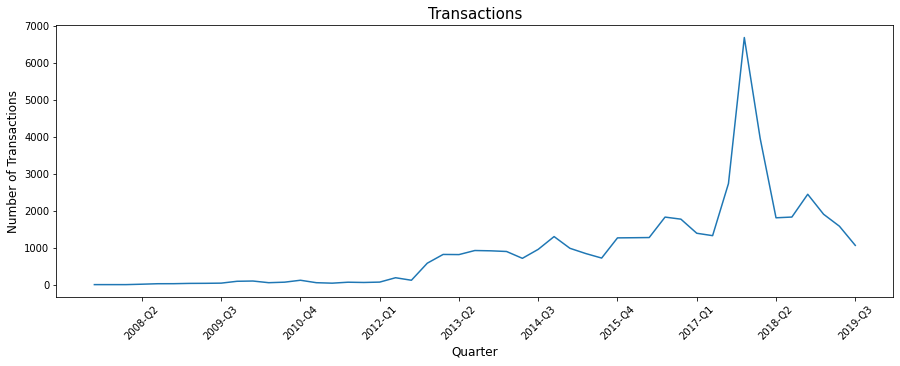

In [114]:
# plot transactions trend 
def plot_transactions_trend(df, tunit='y-m', col_agg='transaction_dt', level='user', xlabel='', ylabel='', title='', figsize=(15, 5)):
    """
    Plot the transactions trend acoss time. 
    
    Args:
        df
        tunit (string): year: 'year', month: 'month', year-month: 'y-m', year-quarter: 'y-q'
        col_agg (string): the column name which is used for aggregation
        level (string): user level: 'user', time unit level: 'tunit'
        
    Returns:
        None
    """
    trend = (df
         .groupby([tunit])[col_agg].count()
         .reset_index()
         .rename(columns={col_agg: 'num_transactions'})
         .sort_values([tunit]))
    
    if level == 'tunit':
        fig = plt.figure(figsize=figsize)
        fig.tight_layout()
        plt.title(title, fontsize=15)
        sns.lineplot(data=trend, x=tunit, y='num_transactions')
        ticks = [i + 3 for i in plt.xticks()[0] if i%5 == 0]
        labels = trend.loc[trend.index.isin(ticks)][tunit].tolist()
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.xticks(ticks = ticks, labels = labels, rotation=45)
        plt.savefig('num_transactions_per_q', dpi=300, bbox_inches='tight');
    
    if level == 'user':
        trend_per_user = (transactions
                          .groupby([tunit, 'user_id'])[col_agg].count()
                          .reset_index()
                          .rename(columns={col_agg: 'num_transactions'})
                          .sort_values([tunit, 'user_id']))

        fig = plt.figure(figsize=(15, 5))
        fig.tight_layout()
        plt.title(title, fontsize=15)
        sns.lineplot(data=trend_per_user, x=tunit, y='num_transactions')
        ticks = [i + 3 for i in plt.xticks()[0] if i%5 == 0]
        labels = trend.loc[trend.index.isin(ticks)][tunit].tolist()
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.xticks(ticks = ticks, labels = labels, rotation=45)
        plt.savefig('avg_transactions_per_user_per_q', dpi=300, bbox_inches='tight');
        
plot_transactions_trend(transactions, 
                        tunit='y-q', 
                        col_agg='transaction_dt', 
                        level='tunit', 
                        xlabel='Quarter',
                        ylabel='Number of Transactions',
                        title='Transactions',
                        figsize=(15, 5))

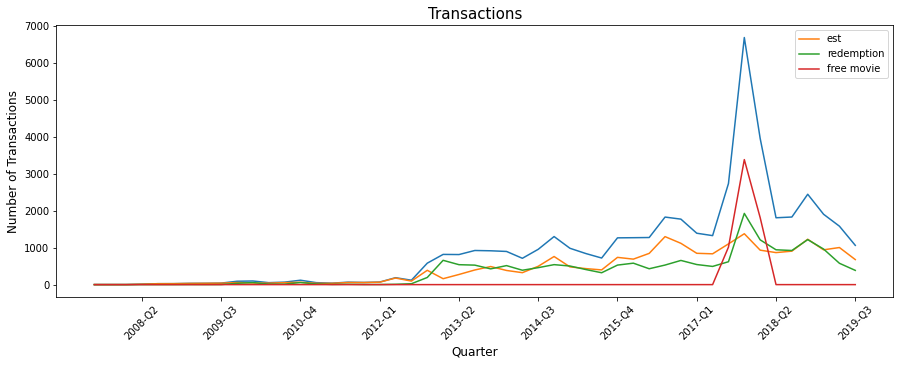

In [233]:
trend = (transactions
     .groupby(['y-q'])['transaction_dt'].count()
     .reset_index()
     .rename(columns={'transaction_dt': 'num_transactions'})
     .sort_values(['y-q']))
trend = pd.merge(trend, (pd.pivot_table(transactions,
               index='y-q',
               columns=['transaction_type'],
               values='transaction_dt',
               aggfunc=lambda x: len(x),
               fill_value=0).reset_index()),
                 on=['y-q'])

fig = plt.figure(figsize=(15, 5))
fig.tight_layout()
plt.title('Transactions', fontsize=15)
sns.lineplot(data=trend, x='y-q', y='num_transactions')
sns.lineplot(data=trend, x='y-q', y='est', label='est')
sns.lineplot(data=trend, x='y-q', y='redemption', label='redemption')
sns.lineplot(data=trend, x='y-q', y='free_movie', label='free movie')
ticks = [i + 3 for i in plt.xticks()[0] if i%5 == 0]
labels = trend.loc[trend.index.isin(ticks)]['y-q'].tolist()
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks = ticks, labels = labels, rotation=45);
plt.savefig('num_transactions_per_type_per_q', dpi=300, bbox_inches='tight');

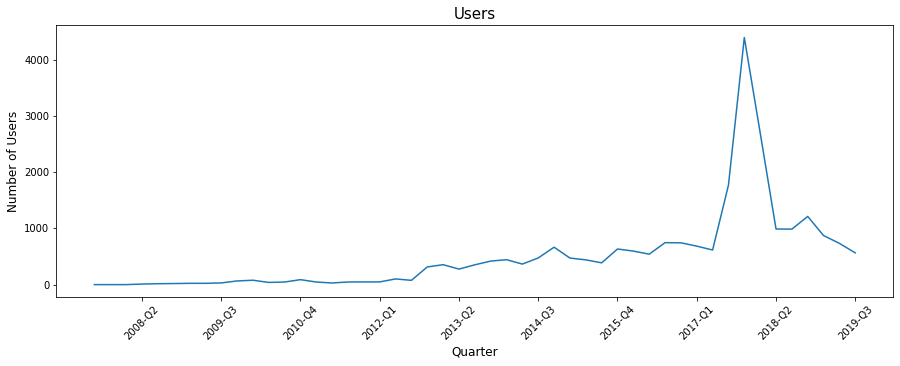

In [115]:
# plot users trend 
def plot_users_trend(df, tunit='y-m', col_agg='user_id', xlabel='', ylabel='', title='', figsize=(15, 5)):
    """
    Plot the number of users trend acoss time. 
    
    Args:
        df
        tunit (string): year: 'year', month: 'month', year-month: 'y-m', year-quarter: 'y-q'
        col_agg (string): user_id, the column name which is used for aggregation

    Returns:
        None
    """
    trend = (df
         .groupby([tunit])[col_agg].nunique()
         .reset_index()
         .rename(columns={col_agg: 'num_users'})
         .sort_values([tunit]))
    
    fig = plt.figure(figsize=figsize)
    fig.tight_layout()
    plt.title(title, fontsize=15)
    sns.lineplot(data=trend, x=tunit, y='num_users')
    ticks = [i + 3 for i in plt.xticks()[0] if i%5 == 0]
    labels = trend.loc[trend.index.isin(ticks)][tunit].tolist()
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(ticks = ticks, labels = labels, rotation=45);
    plt.savefig('num_users_per_q', dpi=300, bbox_inches='tight');
    
        
plot_users_trend(transactions, 
                 tunit='y-q', 
                 col_agg='user_id', 
                 xlabel='Quarter',
                 ylabel='Number of Users',
                 title='Users',
                 figsize=(15, 5))

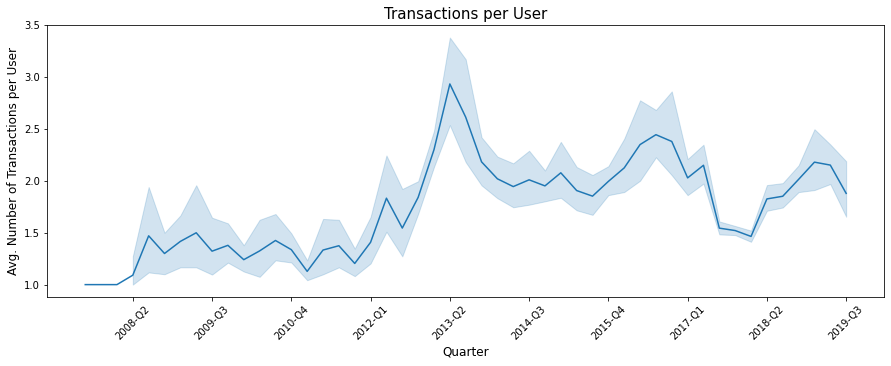

In [116]:
plot_transactions_trend(transactions, 
                        tunit='y-q', 
                        col_agg='transaction_dt', 
                        level='user', 
                        xlabel='Quarter',
                        ylabel='Avg. Number of Transactions per User',
                        title='Transactions per User',
                        figsize=(15, 5))

#### Analysis 2: Churn - Retention Analysis

In [117]:
overall_churn = transactions.sort_values(['y-q']).groupby(['y-q'])['user_id'].nunique().reset_index().rename(columns={'user_id':'current_month_num_users'})
year_quarter_list = []

for y in transactions['y-q'].apply(lambda x: x.split('-')[0]).sort_values().unique().tolist():
    year_quarter_list.extend([y + '-' + m for m in ['Q1', 'Q2', 'Q3', 'Q4']])
    
overall_churn = pd.merge(pd.DataFrame(year_quarter_list, columns=['y-q']), 
                         overall_churn, 
                         how='left',
                         on='y-q').fillna(0)

overall_churn['previous_month_num_users'] = overall_churn['current_month_num_users'].shift(1)
overall_churn['num_churns'] = overall_churn['previous_month_num_users'] - overall_churn['current_month_num_users']
overall_churn['churn_rate'] = overall_churn['num_churns'] / overall_churn['previous_month_num_users']
overall_churn = overall_churn.loc[lambda x: x['y-q'] != '2019-Q4']
overall_churn

,y-q,current_month_num_users,previous_month_num_users,num_churns,churn_rate
0,2006-Q1,0.0,NaN,NaN,NaN
1,2006-Q2,0.0,0.0,0.0,NaN
2,2006-Q3,1.0,0.0,-1.0,-inf
3,2006-Q4,0.0,1.0,1.0,1.000000
4,2007-Q1,1.0,0.0,-1.0,-inf
5,2007-Q2,1.0,1.0,0.0,0.000000
6,2007-Q3,0.0,1.0,1.0,1.000000
7,2007-Q4,0.0,0.0,0.0,NaN
8,2008-Q1,0.0,0.0,0.0,NaN
9,2008-Q2,11.0,0.0,-11.0,-inf


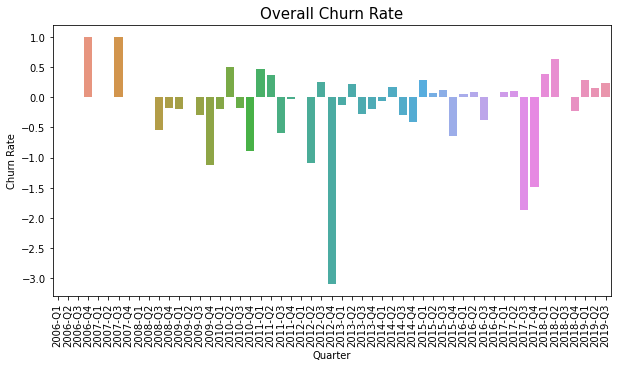

In [118]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=overall_churn, x='y-q', y='churn_rate')
plt.title('Overall Churn Rate', size=15)
ax.tick_params(axis='x', rotation=90)
plt.ylabel('Churn Rate')
plt.xlabel('Quarter')
plt.savefig('churn.jpg', dpi=300, bbox_inches='tight');

In [215]:
# movie
transactions.loc[transactions['y-q'] == '2018-Q1']['title_name'].value_counts()

GHOSTBUSTERS (2016)                                    1839
SPIDER-MAN: HOMECOMING                                  296
JUMANJI (1995)                                          146
BABY DRIVER                                             103
CALL ME BY YOUR NAME                                     69
EMOJI MOVIE, THE                                         45
HOTEL TRANSYLVANIA 2                                     35
PASSENGERS (2016)                                        35
DARK CRYSTAL, THE                                        33
LIFE (2017)                                              29
AMAZING SPIDER-MAN 2, THE                                25
FURY                                                     24
LABYRINTH (1986)                                         23
22 JUMP STREET                                           23
HOTEL TRANSYLVANIA                                       22
INSIDIOUS: CHAPTER 2                                     22
INSIDIOUS: CHAPTER 3                    

In [221]:
# promotion
transactions.loc[transactions['y-q'] == '2018-Q2']['transaction_type'].value_counts()

redemption    942
est           866
Name: transaction_type, dtype: int64

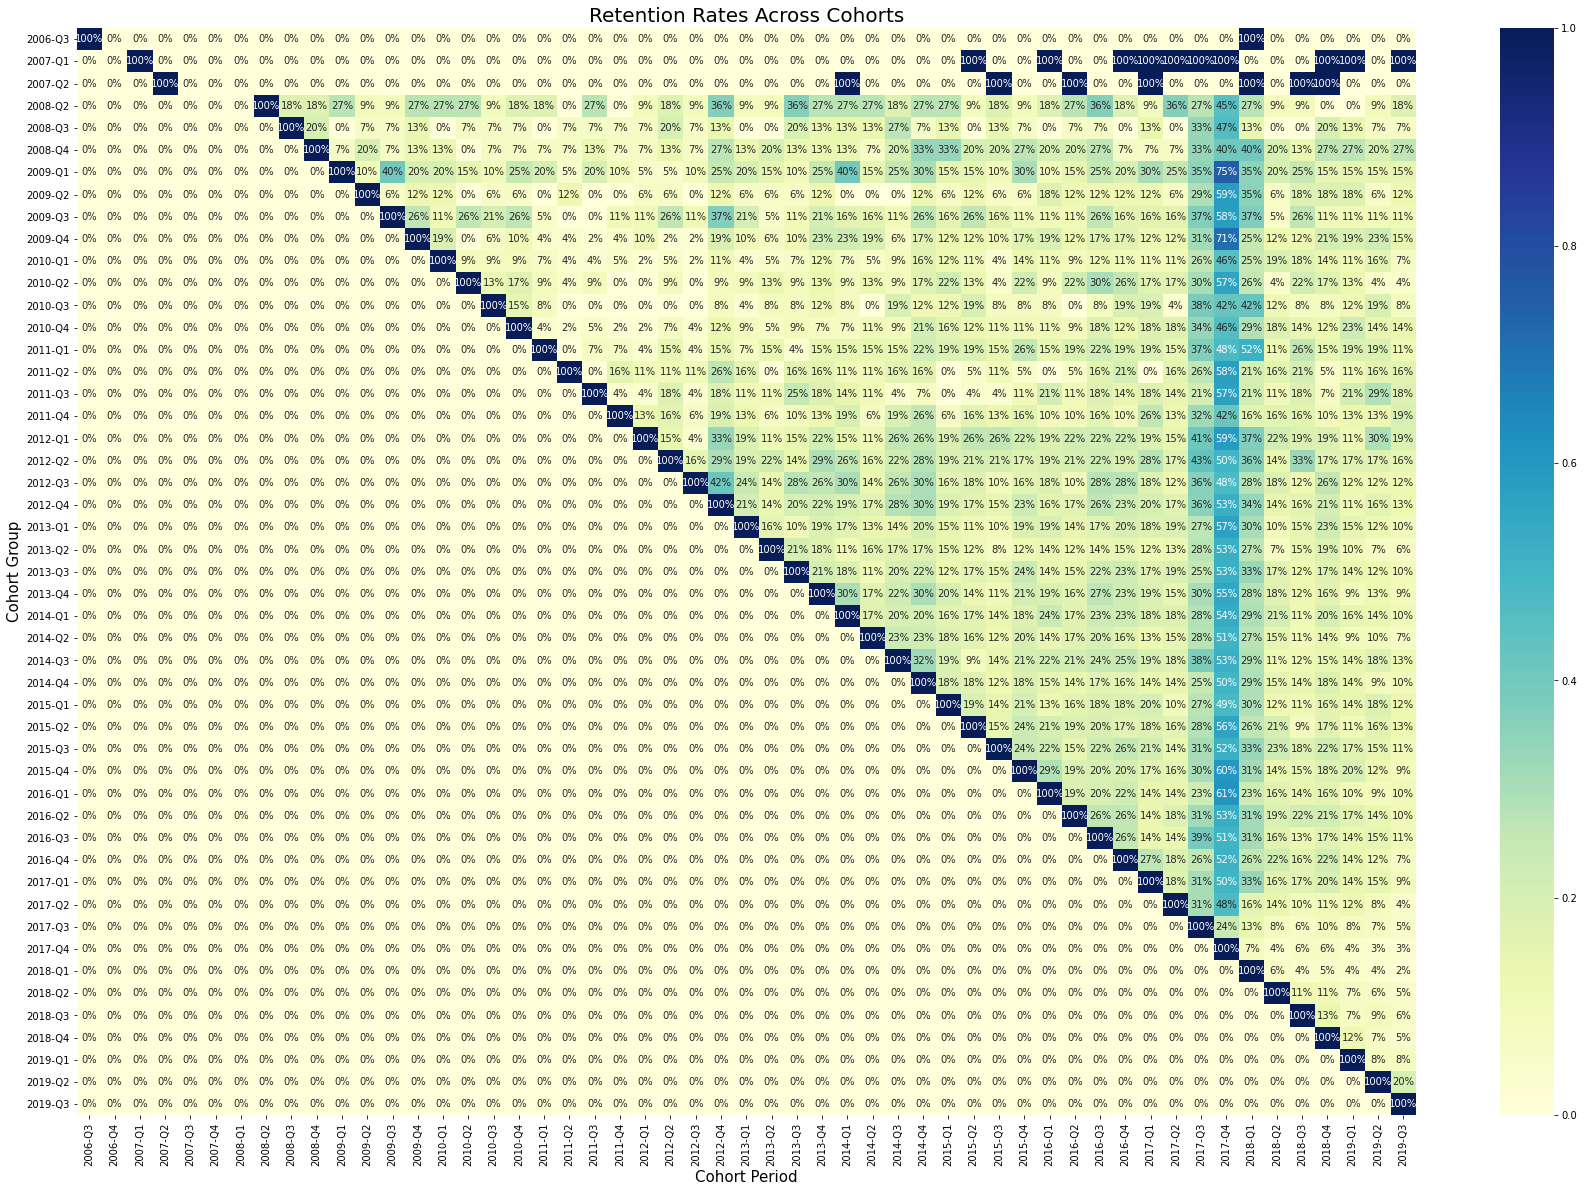

In [119]:
def plot_retention_analysis(df, tunit='y-m', figsize=(30,20)):
    """
    Plot the retention analysis for each user cohert.
    
    Args:
        df: transactions
        tunit (string): year-month: 'y-m', year-quarter: 'y-q'
    
    """
    retention = (df
                 .groupby(['y-m', 'user_id'])['transaction_dt'].count()
                 .reset_index()
                 .rename(columns={'transaction_dt':'num_transactions'})
                 .sort_values(['user_id', 'y-m']))
    
    year_month_list = []
    
    for y in retention['y-m'].apply(lambda x: x.split('-')[0]).unique().tolist():
        year_month_list.extend([y + '-' + m for m in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']])
    
    # create cohert and timeunit columns
    prefix = (pd
              .merge(pd.DataFrame(year_month_list, columns=['y-m']), 
                     retention[['user_id']].drop_duplicates(), 
                     how='cross')
              .merge(retention
                     .groupby(['user_id'])['y-m'].first()
                     .reset_index()
                     .rename(columns={'y-m':'cohert-m'}), 
                     on='user_id')
              .loc[lambda x: x['y-m'] >= x['cohert-m']])
    
    retention = pd.merge(prefix, retention, on=['y-m', 'user_id'], how='left').sort_values(['y-m', 'user_id']).fillna(0)
    retention['if_transactions'] = retention['num_transactions'].apply(lambda x: 1 if x >=1 else 0)
    
    cohert = 'cohert-m'
    
    if tunit == 'y-q':
        cohert = 'cohert-q'
        retention['y-q'] = retention['y-m'].apply(lambda x: x.split('-')[0] + '-Q' + str((int(x.split('-')[1]) - 1)//3 + 1))
        retention['cohert-q'] = retention['cohert-m'].apply(lambda x: x.split('-')[0] + '-Q' + str((int(x.split('-')[1]) - 1)//3 + 1))
        
    retention = retention.groupby([cohert, tunit]).apply(lambda x: x.loc[x['if_transactions'] == 1]['user_id'].nunique() / x['user_id'].nunique()).reset_index().rename(columns={0:'retention_rate'})
    retention = pd.pivot_table(retention,
                   index=cohert,
                   columns=tunit,
                   values='retention_rate',
                   aggfunc=lambda x: np.round(x, 5),
                   fill_value=0).drop(columns=['2019-Q4'])
    
    fig = plt.figure(figsize=figsize)
    fig.tight_layout()
    sns.heatmap(retention, annot=True, cmap="YlGnBu", fmt='.0%')
    
    plt.xlabel('Cohort Period', fontsize = 15)
    plt.ylabel('Cohort Group', fontsize = 15)
    plt.title('Retention Rates Across Cohorts', fontsize = 20)
    plt.savefig('retention.jpg', dpi=500)
    
    plt.show()
    
    
plot_retention_analysis(transactions, 
                        tunit='y-q', 
                        figsize=(30,20))

In [120]:
print('avg. 1st quarter churn rate = 17.13%')

avg. 1st quarter churn rate = 17.13%


#### users
- total users: 8879
- user may register multiple times: 15 users have more than 1 registration, and all of them have 2 registrations
- 54 missing in the dominant client type
- users registration from Jul, 2017 to Feb, 2019
- top 3 dominant client types: Web, IOS, Android

In [121]:
users.head()

,user_id,registration_date,dominant_client_type
7638,-2138,2017-09-04,IOS
7815,680,2018-02-06,WEB
7613,1016,2017-07-28,FIRE_TV
408,2314,2018-01-08,WEB
8825,2472,2017-08-18,ANDROID


In [122]:
print('1. number of records =', len(users))
print('2. number of users =', users['user_id'].nunique())
print('3. missing values:')
print(users.isnull().sum())
print('4. registrations from {} to {}'.format(str(users['registration_date'].min()).split(' ')[0], str(users['registration_date'].max()).split(' ')[0]))
print('5. dominant client types:')
users['dominant_client_type'].value_counts()

1. number of records = 8894
2. number of users = 8879
3. missing values:
user_id                  0
registration_date        0
dominant_client_type    54
dtype: int64
4. registrations from 2017-07-04 to 2019-02-14
5. dominant client types:


WEB           3523
IOS           2627
ANDROID       1845
FIRE_TV        298
ROKU           238
TV_OS          118
KINDLE          74
PS4             61
ANDROID_TV      56
Name: dominant_client_type, dtype: int64

In [123]:
# imputation
def impute_dominant_client_type(users):
    """impute column 'dominant_client_type'."""
    users['dominant_client_type'] = users['dominant_client_type'].fillna('NA')
    
    return users

users = impute_dominant_client_type(users)

#### Analysis 3: Explore Multiple Registrations - Behavior Pattern

In [124]:
# user who has more than 1 registration
multi_reg = (users
             .sort_values(['user_id'])
             .groupby(['user_id'])['registration_date'].count()
             .reset_index()
             .loc[lambda x: x['registration_date'] > 1]
             .rename(columns={'registration_date': 'num_registrations'})
             .reset_index(drop=True)
             .sort_values(['user_id']))

multi_reg = pd.merge(multi_reg,
                     (users
                      .sort_values(['user_id', 'registration_date'])
                      .loc[users['user_id'].isin(multi_reg['user_id'])]
                      .groupby(['user_id'])
                      .apply(lambda x: ' | '.join(x['registration_date'].astype(str) + ' ' + x['dominant_client_type']))
                      .reset_index()
                      .rename(columns={0:'registrations'})),
                     on='user_id'
                     )
multi_reg = pd.merge(multi_reg,
                     (transactions
                      .sort_values(['user_id', 'transaction_dt'])
                      .loc[lambda x: x['user_id']
                           .isin(multi_reg['user_id'])]
                      .groupby(['user_id'])
                      .apply(lambda x: ' --> '.join(x['transaction_dt'].astype(str)))
                      .reset_index()
                      .rename(columns={0:'transactions'})),
                     on='user_id'
                     )
multi_reg

,user_id,num_registrations,registrations,transactions
0,64247,2,2017-07-16 ANDROID | 2017-11-03 ROKU,2017-09-30 --> 2018-01-19 --> 2018-10-12
1,404153,2,2017-08-28 IOS | 2017-11-30 WEB,2015-12-21 --> 2015-12-24 --> 2016-01-05 --> 2016-01-26 --> 2016-07-20 --> 2016-09-25 --> 2017-09-14 --> 2017-09-14 --> 2017-09-17 --> 2017-09-25 --> 2017-11-13 --> 2017-11-16 --> 2018-01-05 --> 2018-01-14 --> 2018-07-14 --> 2018-08-28 --> 2019-02-08
2,545258,2,2017-11-08 WEB | 2017-11-24 WEB,2017-12-31 --> 2018-01-23
3,768967,2,2017-08-27 IOS | 2017-11-03 WEB,2013-05-28 --> 2017-10-11 --> 2018-01-14
4,1034689,2,2017-10-19 IOS | 2017-12-19 WEB,2010-12-29 --> 2017-11-05 --> 2018-01-29
5,1112259,2,2017-08-15 IOS | 2018-02-19 WEB,2010-02-17 --> 2010-05-21 --> 2010-08-06 --> 2010-08-07 --> 2011-12-26 --> 2012-04-04 --> 2012-05-17 --> 2012-10-06 --> 2012-11-02 --> 2012-12-01 --> 2013-04-11 --> 2013-05-28 --> 2013-06-14 --> 2013-06-19 --> 2013-09-23 --> 2013-12-06 --> 2014-01-06 --> 2014-04-14 --> 2014-08-07 --> 2015-01-10 ...
6,1209628,2,2017-07-16 ANDROID | 2017-07-16 IOS,2017-09-24 --> 2017-10-07
7,1353950,2,2017-11-20 ANDROID | 2018-04-15 WEB,2016-07-28 --> 2016-12-13 --> 2016-12-23 --> 2017-01-02 --> 2017-06-11 --> 2018-01-18
8,1506462,2,2017-07-15 ANDROID | 2018-03-02 ANDROID,2017-09-22 --> 2018-04-18 --> 2018-04-27
9,1525882,2,2017-07-30 WEB | 2017-10-25 WEB,2009-10-01 --> 2011-12-18 --> 2012-01-19 --> 2013-01-22 --> 2017-10-04 --> 2017-11-23 --> 2017-11-25 --> 2017-12-01 --> 2017-12-07


#### Data Quality: users

In [125]:
def adjust_users(users):
    """improve the quality of the users table and make sure user_id is primary, unique, and not negative.""" 
    
    def make_unique(user):
        """when a single user_id has multiple records, combine them as one."""
        registration_date = user['registration_date'].min() # ealiest registration date is the when someone started to be an user
        dominant_client_type = '/'.join(user['dominant_client_type'].tolist()) # if multiple client type, combine all
        return pd.DataFrame([[registration_date, dominant_client_type]], columns=user.columns[1:])
    
    def adjust_negative_user_id(users):
        users['user_id'] = users['user_id'].apply(lambda x: -x if x < 0 and -x not in users['user_id'].tolist() else x)
        return users
    
    users = users.groupby(['user_id']).apply(make_unique).reset_index().drop(columns=['level_1'], errors='ignore').pipe(adjust_negative_user_id)
    
    return users

users = adjust_users(users).sort_values(['user_id'])

#### title 
- total movies: 468
- 6 movies have more than 1 version, either 2 or 3
- top 3 genre: comedy, drama, action
- boxoffice from 6422 usd (BLONDE AMBITION) to 334201140 usd (SPIDER-MAN: HOMECOMING)

In [126]:
titles.head()

,title_eidr,title_name,primary_genre,release_year,boxoffice_us,rt_critic_score
395,10.5240/00CE-6E2C-2821-BD8D-30BA-O,NOTHING IN COMMON (1986),Comedy,1986,32324557.0,58
60,10.5240/0125-1227-217B-F81D-D925-4,AMERICAN POP,Music,1981,6000000.0,59
406,10.5240/012A-C16B-454C-BD39-A93E-M,GLADIATOR (1992),Action,1992,9223441.0,25
416,10.5240/0155-2888-78DF-4D60-0FAB-4,MIDNIGHT EXPRESS (1978),Drama Classic,1978,35000000.0,95
355,10.5240/01F6-065B-A63C-41A4-E79C-6,"CRAFT, THE",Thriller,1996,24881000.0,50


In [127]:
print('1. number of records =', len(titles))
print('2. number of titles =', titles['title_eidr'].nunique())
print('3. missing values:')
print(titles.isnull().sum())
print('4. release year from {} to {}'.format(titles.loc[titles['release_year'] != 0]['release_year'].min(), titles['release_year'].max()))
print('5. movies with release year = 0 are', titles.loc[titles['release_year'] == 0]['title_eidr'].nunique())
print('6. movie genre:')
print(titles['primary_genre'].value_counts())

1. number of records = 476
2. number of titles = 468
3. missing values:
title_eidr         0
title_name         0
primary_genre      0
release_year       0
boxoffice_us       0
rt_critic_score    0
dtype: int64
4. release year from 1939 to 2017
5. movies with release year = 0 are 3
6. movie genre:
Comedy              126
Drama               118
Action               79
Horror               25
Family               19
Thriller             16
Sci-Fi               13
Drama Classic        13
Adventure             9
Award Winning         9
Children/Family       8
Romantic Comedy       5
Documentary           5
Suspense              4
Musical               4
Crime                 4
Animation             2
Comedy Romance        2
Music                 2
Action/Adventure      2
Children              2
Drama Romance         2
Western               2
Comedy Classic        1
Sci-Fi/Fantasy        1
Romance               1
Biography             1
War                   1
Name: primary_genre, dtype: i

In [128]:
# case when a single title _eidr has multiple records
multi_title_names_list = titles.groupby(['title_eidr'])['title_name'].count().reset_index().loc[lambda x: x['title_name'] > 1]['title_eidr'].tolist()
titles.loc[titles['title_eidr'].isin(multi_title_names_list)].sort_values(by=['title_eidr', 'release_year'])

,title_eidr,title_name,primary_genre,release_year,boxoffice_us,rt_critic_score
130,10.5240/257C-777E-76A2-E7AA-6552-3,"BRIDGE ON THE RIVER KWAI, THE (ORIGINAL VERSION)",War,1957,44908000.0,94
313,10.5240/257C-777E-76A2-E7AA-6552-3,"BRIDGE ON THE RIVER KWAI, THE (RESTORED VERSION)",Drama,1985,44908000.0,94
468,10.5240/3768-CC96-51EC-64D0-A6F7-N,LAWRENCE OF ARABIA (RESTORED VERSION),Drama Classic,1962,44824144.0,97
442,10.5240/3768-CC96-51EC-64D0-A6F7-N,LAWRENCE OF ARABIA (ORIGINAL),Drama,1962,44824144.0,97
149,10.5240/5F24-2035-423C-25F5-4BD3-A,"LAST PICTURE SHOW, THE (DIRECTOR'S CUT)",Drama Classic,0,29133000.0,100
418,10.5240/5F24-2035-423C-25F5-4BD3-A,"LAST PICTURE SHOW, THE (ORIGINAL)",Drama,1971,29133000.0,100
322,10.5240/5F24-2035-423C-25F5-4BD3-A,"LAST PICTURE SHOW, THE (DIRECTOR'S CUT)",Drama Classic,1971,29133000.0,100
264,10.5240/8C7E-E8A7-943A-8273-83F0-F,BEFORE MIDNIGHT (CRITERION),Drama,0,8114627.0,98
49,10.5240/8C7E-E8A7-943A-8273-83F0-F,BEFORE MIDNIGHT (2013),Drama,2013,8114627.0,98
343,10.5240/FA8B-8141-7F8A-EE51-73A2-6,LAKE PLACID (1999),Action,0,31770414.0,40


#### Data Quality: titles

In [129]:
# improve the quality of titles
def adjust_titles(titles):
    """improve the quality of the table and make sure title_eidr is primary and unique.""" 
    
    def make_unique(title):
        """when a single title_eidr has multiple records, choose only one value."""
        # TO DO LIST: improve the following rule in the future
        title = title.sort_values(['title_eidr', 'release_year']).loc[title['release_year'] != 0]
        title_name = title['title_name'].values[0] # select any value
        primary_genre = ' '.join(title['primary_genre']
                                 .str.replace('/', ' ')
                                 .str.replace('Award Winning', 'AwardWinning')
                                 .str.replace('Romance', 'Romantic')
                                 .tolist()) # genre could be different and we keep all of them
        release_year = title['release_year'].astype(int).min() # respect the original version
        boxoffice_us = title['boxoffice_us'].values[0] # select any value, usually they are all same
        rt_critic_score = title['rt_critic_score'].values[0] # select any value, usually they are all same
        
        return pd.DataFrame([[title_name, primary_genre, release_year, boxoffice_us, rt_critic_score]], columns=title.columns[1:])
    
    return titles.groupby(['title_eidr']).apply(make_unique).reset_index().drop(columns=['level_1'], errors='ignore')

titles = adjust_titles(titles)

In [130]:
titles.head()

,title_eidr,title_name,primary_genre,release_year,boxoffice_us,rt_critic_score
0,10.5240/00CE-6E2C-2821-BD8D-30BA-O,NOTHING IN COMMON (1986),Comedy,1986,32324557.0,58
1,10.5240/0125-1227-217B-F81D-D925-4,AMERICAN POP,Music,1981,6000000.0,59
2,10.5240/012A-C16B-454C-BD39-A93E-M,GLADIATOR (1992),Action,1992,9223441.0,25
3,10.5240/0155-2888-78DF-4D60-0FAB-4,MIDNIGHT EXPRESS (1978),Drama Classic,1978,35000000.0,95
4,10.5240/01F6-065B-A63C-41A4-E79C-6,"CRAFT, THE",Thriller,1996,24881000.0,50


In [131]:
titles['boxoffice_us'] = titles['boxoffice_us'].astype(int)
print('Box Office:')
print('1. us boxoffice from {} to {} usd'.format(titles['boxoffice_us'].min(), titles['boxoffice_us'].max()))
print('2. film having lowest boxoffice =', titles.loc[titles['boxoffice_us'] == 6422]['title_name'].values)
print('film having highest boxoffice =', titles.loc[titles['boxoffice_us'] == 334201140]['title_name'].values)

Box Office:
1. us boxoffice from 6422 to 334201140 usd
2. film having lowest boxoffice = ['BLONDE AMBITION']
film having highest boxoffice = ['SPIDER-MAN: HOMECOMING']


In [132]:
titles['rt_critic_score'] = titles['rt_critic_score'].astype(int)
print('Rotted Tomatos Score:')
print('rotten tomatos critic score from {} to {}'.format(titles['rt_critic_score'].min(), titles['rt_critic_score'].max()))
print('film having lowest boxoffice =', titles.loc[titles['rt_critic_score'] == titles['rt_critic_score'].min()]['title_name'].values)
print('film having highest boxoffice =', titles.loc[titles['rt_critic_score'] == titles['rt_critic_score'].max()]['title_name'].values)

Rotted Tomatos Score:
rotten tomatos critic score from 3 to 100
film having lowest boxoffice = ['JACK AND JILL']
film having highest boxoffice = ['RICHARD PRYOR LIVE ON THE SUNSET STRIP' 'CALL ME BY YOUR NAME'
 'CAT BALLOU (1965)' 'LAST PICTURE SHOW, THE (ORIGINAL)' 'CACTUS FLOWER'
 'ANATOMY OF A MURDER' 'COMPETITION, THE' 'MAROONED'
 'BUDDY HOLLY STORY, THE' 'HARD TIMES']


In [133]:
# days between two consecutive transactions
def create_days_btwn_consec_transactions(transactions):
    if 'nxt_transaction_dt' not in transactions.columns:
        transactions = pd.concat([transactions.sort_values(by=['user_id', 'transaction_dt']).reset_index(drop=True),
                                         (transactions
                                          .sort_values(by=['user_id', 'transaction_dt'])
                                          .reset_index(drop=True)
                                          .groupby(['user_id']).apply(lambda x: x['transaction_dt'].shift(-1))
                                          .reset_index()[['transaction_dt']]
                                          .rename(columns={'transaction_dt':'nxt_transaction_dt'}))],
                                        axis=1)
    transactions['days_btwn_two_trans'] = (transactions['nxt_transaction_dt'] - transactions['transaction_dt']).apply(lambda x: int(str(x).split(' ')[0]) if str(x) != 'NaT' else x)
    
    return transactions

transactions = create_days_btwn_consec_transactions(transactions)

#### Analysis 4: Movie Watching Interval in Days

(0.0, 5000.0)

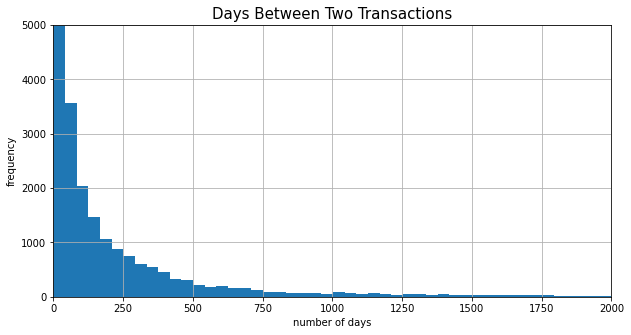

In [134]:
plt.figure(figsize=(10, 5))
plt.title('Days Between Two Transactions', fontsize=15)
transactions['days_btwn_two_trans'].hist(bins=100)
plt.xlabel('number of days')
plt.ylabel('frequency')
plt.xlim(0, 2000)
plt.ylim(0, 5000)

### 2.1.2 User-level Metrics Design and Creation

#### List of Metrics
- Journey: 
	- 'days_btwn_reg_and_oct2019' 
	- 'num_transactions 
	- 'num_trans_before_reg'
	- 'num_trans_on_reg'
	- 'num_trans_within_30_days_reg'
	- 'num_trans_30_to_60_days_reg' 
	- 'num_trans_60_to_90_days_reg'
	- 'num_trans_over_90days_reg' 
	- 'num_movies'
    
- Behavior: 
    - Recency: 
        - 'days_btwn_lst_trandt_and_oct2019'
    - Device Type: 
        - 'num_trans_android'
        - 'num_trans_android/android'
        - 'num_trans_android_tv'
        - 'num_trans_android_tv/ios'
        - 'num_trans_fire_tv'
        - 'num_trans_ios'
        - 'num_trans_ios/android'
        - 'num_trans_ios/web'
        - 'num_trans_kindle'
        - 'num_trans_na'
        - 'num_trans_ps4'
        - 'num_trans_roku'
        - 'num_trans_android/roku'
        - 'num_trans_tv_os'
        - 'num_trans_web'
        - 'num_trans_web/android'
        - 'num_trans_web/ios'
        - 'num_trans_web/web'
    - Transaction Type:
        - 'num_transaction_types'
        - 'num_trans_est'
        - 'num_trans_free_movie'
        - 'num_trans_redemption'
    - Preference & Taste
    
        - Movie Genre:
            - 'num_trans_comedy', 
            - 'num_trans_music', 
            - 'num_trans_action', 
            - 'num_trans_drama', 
            - 'num_trans_classic', 
            - 'num_trans_thriller', 
            - 'num_trans_sci-fi', 
            - 'num_trans_documentary', 
            - 'num_trans_romantic', 
            - 'num_trans_horror', 
            - 'num_trans_children', 
            - 'num_trans_family', 
            - 'num_trans_crime', 
            - 'num_trans_western', 
            - 'num_trans_suspense', 
            - 'num_trans_war', 
            - 'num_trans_awardwinning', 
            - 'num_trans_adventure', 
            - 'num_trans_musical', 
            - 'num_trans_animation', 
            - 'num_trans_biography', 
            - 'num_trans_fantasy'
	
        - Generation
            - 'num_release_year_ranges'
            - 'num_trans_release_year_1980-1989'
            - 'num_trans_release_year_1990-1999'
            - 'num_trans_release_year_2000-2009'
            - 'num_trans_release_year_2010-2019'
            - 'num_trans_release_year_<1980'
    
        - Crowding
            - 'num_boxoffice_us_ranges'
            - 'num_trans_boxoffice_us_1-5million'
            - 'num_trans_boxoffice_us_10-50million'
            - 'num_trans_boxoffice_us_5-10million'
            - 'num_trans_boxoffice_us_50-100million'
            - 'num_trans_boxoffice_us_<1million'
            - 'num_trans_boxoffice_us_>100million'
    
        - Chasing
            - 'num_trans_0year_btwn_trandt_and_release_year'
            - 'num_trans_1-5years_btwn_trandt_and_release_year'
            - 'num_trans_6-10years_btwn_trandt_and_release_year'
            - 'num_trans_>10years_btwn_trandt_and_release_year'
        
        - Repeating
            - 'max_num_trans_for_a_movie'

In [135]:
feature_categories = {
    'journey': [
        'days_btwn_reg_and_oct2019', 
        'num_transactions', 
        'num_trans_before_reg', 
        'num_trans_on_reg', 
        'num_trans_within_30_days_reg', 
        'num_trans_30_to_60_days_reg', 
        'num_trans_60_to_90_days_reg', 
        'num_trans_over_90days_reg', 
        'num_movies'
    ],
    'recency': [
        'days_btwn_lst_trandt_and_oct2019'
    ],
    'device type': [
        'num_trans_android', 
        'num_trans_android/android', 
        'num_trans_android_tv', 
        'num_trans_android_tv/ios', 
        'num_trans_fire_tv', 
        'num_trans_ios', 
        'num_trans_ios/android', 
        'num_trans_ios/web', 
        'num_trans_kindle', 
        'num_trans_na', 
        'num_trans_ps4', 
        'num_trans_roku', 
        'num_trans_android/roku', 
        'num_trans_tv_os', 
        'num_trans_web', 
        'num_trans_web/android', 
        'num_trans_web/ios', 
        'num_trans_web/web'
    ],
    'transaction type': [
        'num_transaction_types', 
        'num_trans_est', 
        'num_trans_free_movie', 
        'num_trans_redemption'
    ],
    'preference - movie genre': [
        'num_trans_comedy', 
        'num_trans_music', 
        'num_trans_action', 
        'num_trans_drama', 
        'num_trans_classic', 
        'num_trans_thriller', 
        'num_trans_sci-fi', 
        'num_trans_documentary', 
        'num_trans_romantic', 
        'num_trans_horror', 
        'num_trans_children', 
        'num_trans_family', 
        'num_trans_crime', 
        'num_trans_western', 
        'num_trans_suspense', 
        'num_trans_war', 
        'num_trans_awardwinning', 
        'num_trans_adventure', 
        'num_trans_musical', 
        'num_trans_animation', 
        'num_trans_biography', 
        'num_trans_fantasy'
    ],
    'preference - generation':[
        'num_release_year_ranges', 
        'num_trans_release_year_1980-1989', 
        'num_trans_release_year_1990-1999', 
        'num_trans_release_year_2000-2009', 
        'num_trans_release_year_2010-2019', 
        'num_trans_release_year_<1980'
    ],
      'preference - crowding': [
          'num_boxoffice_us_ranges', 
          'num_trans_boxoffice_us_1-5million', 
          'num_trans_boxoffice_us_10-50million', 
          'num_trans_boxoffice_us_5-10million', 
          'num_trans_boxoffice_us_50-100million', 
          'num_trans_boxoffice_us_<1million', 
          'num_trans_boxoffice_us_>100million'
      ], 
   'preference - chasing':[
       'num_trans_0year_btwn_trandt_and_release_year', 
       'num_trans_1-5years_btwn_trandt_and_release_year', 
       'num_trans_6-10years_btwn_trandt_and_release_year', 
       'num_trans_>10years_btwn_trandt_and_release_year'
   ],   
    'preference - repeating': [
        'max_num_trans_for_a_movie'
 ]
}

In [136]:
# merge users and titles into transactions
def merge_all_tables(transactions, titles, users):
    if 'registration_date' not in transactions.columns:
        transactions = pd.merge(users,
                                transactions,
                                on='user_id')
        
    if 'title_name' not in transactions.columns:
        transactions = pd.merge(titles,
                                transactions,
                                on='title_eidr')
    
    return transactions

transactions = merge_all_tables(transactions, titles, users)

In [137]:
# initialize the dataframe
df = pd.DataFrame()
df['user_id'] = users['user_id'].unique()

In [138]:
# 1. days between registration and Oct-2019
def create_days_btwn_reg_and_oct2019(df, transactions=transactions):
    transactions['days_btwn_reg_and_oct2019'] = (pd.to_datetime('10-01-2019') - transactions['registration_date']).apply(lambda x: int(str(x).split(' ')[0]))
    if 'days_btwn_reg_and_oct2019' not in df.columns:
        df = pd.merge(df,
                      transactions.groupby(['user_id'])['days_btwn_reg_and_oct2019'].max(),
                      on='user_id')
    return df

df = create_days_btwn_reg_and_oct2019(df)
df.head()

,user_id,days_btwn_reg_and_oct2019
0,680,602
1,1016,795
2,2314,631
3,2472,774
4,2673,748


In [139]:
# 2. days between last transaction date and Oct-2019
def create_days_btwn_trandt_and_oct2019(df, transactions=transactions):
    transactions['days_btwn_trandt_and_oct2019'] = (pd.to_datetime('10-01-2019') - transactions['transaction_dt']).apply(lambda x: int(str(x).split(' ')[0]))
    if 'days_btwn_lst_trandt_and_oct2019' not in df.columns:
        df = pd.merge(df,
                      transactions.groupby(['user_id'])['days_btwn_trandt_and_oct2019'].min(),
                      on='user_id').rename(columns={'days_btwn_trandt_and_oct2019': 'days_btwn_lst_trandt_and_oct2019'})
    return df

df = create_days_btwn_trandt_and_oct2019(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019
0,680,602,196
1,1016,795,736
2,2314,631,113
3,2472,774,598
4,2673,748,267


In [140]:
# 3. number of transactions
def create_num_transactions(df, transactions=transactions):
    if 'num_transactions' not in df.columns:
        df = pd.merge(df,
                      transactions.groupby(['user_id'])['transaction_dt'].count(),
                      on='user_id').rename(columns={'transaction_dt': 'num_transactions'})
    return df

df = create_num_transactions(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions
0,680,602,196,4
1,1016,795,736,1
2,2314,631,113,9
3,2472,774,598,2
4,2673,748,267,5


In [141]:
# 4. number of transactions in the before registration, on registration date, within 30, 60, 90, >90 days since the earlist registration
def create_num_trans_before_reg(df, transactions=transactions):
    transactions['days_btwn_reg_and_trandt'] = (transactions['transaction_dt'] - transactions['registration_date']).apply(lambda x: int(str(x).split(' ')[0]))
    # 24141 transactions were before the users' registrations dates: transactions.loc[transactions['days_btwn_reg_and_trandt'] < 0] 
    transactions.loc[lambda x: x['days_btwn_reg_and_trandt'] < 0, 'if_before_reg'] = 1
    transactions.loc[lambda x: x['days_btwn_reg_and_trandt'] == 0, 'if_on_reg'] = 1
    transactions.loc[lambda x: (x['days_btwn_reg_and_trandt'] > 0) & (x['days_btwn_reg_and_trandt'] <= 30), 'if_within_30_days_reg'] = 1
    transactions.loc[lambda x: (x['days_btwn_reg_and_trandt'] > 30) & (x['days_btwn_reg_and_trandt'] <= 60), 'if_30_to_60_days_reg'] = 1
    transactions.loc[lambda x: (x['days_btwn_reg_and_trandt'] > 60) & (x['days_btwn_reg_and_trandt'] <= 90), 'if_60_to_90_days_reg'] = 1
    transactions.loc[lambda x: (x['days_btwn_reg_and_trandt'] > 90), 'if_over_90days_reg'] = 1
    transactions = transactions.fillna(0)
    
    if 'num_trans_before_reg' not in df.columns:
        df = pd.merge(df,
                      transactions.groupby(['user_id'])[['if_before_reg', 'if_on_reg', 'if_within_30_days_reg', 'if_30_to_60_days_reg', 'if_60_to_90_days_reg', 'if_over_90days_reg']].agg('sum').reset_index(),
                      on='user_id').rename(columns={'if_before_reg': 'num_trans_before_reg', 
                                                    'if_on_reg': 'num_trans_on_reg', 
                                                    'if_within_30_days_reg': 'num_trans_within_30_days_reg', 
                                                    'if_30_to_60_days_reg': 'num_trans_30_to_60_days_reg', 
                                                    'if_60_to_90_days_reg': 'num_trans_60_to_90_days_reg', 
                                                    'if_over_90days_reg': 'num_trans_over_90days_reg'})
    return df

df = create_num_trans_before_reg(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0


In [142]:
# 5. number of movies
def create_num_movies(df, transactions=transactions):
    if 'num_movies' not in df.columns:
        df = pd.merge(df,
                      transactions.groupby(['user_id'])['title_eidr'].nunique().reset_index(),
                      on='user_id').rename(columns={'title_eidr': 'num_movies'})
    
    return df

df = create_num_movies(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3


In [143]:
# number of transactions on each dominant_client_type
def create_num_trans_per_client_type(df, transactions=transactions):
    num_trans_per_client_type = pd.pivot_table(transactions,
                                               index='user_id', 
                                               values=['transaction_dt'],
                                               columns=['dominant_client_type'],
                                               aggfunc=lambda x: len(x),
                                               fill_value=0).reset_index()
    num_trans_per_client_type.columns = ['num_trans_' + str(num_trans_per_client_type.columns[i][1]).lower()
                                         if (num_trans_per_client_type.columns[i][1] != '') 
                                         else str(num_trans_per_client_type.columns[i][0]).lower()
                                         for i in range(len(num_trans_per_client_type.columns))]
    
    if 'num_trans_android' not in df.columns:
        df = pd.merge(df,
                      num_trans_per_client_type,
                      on='user_id')
    
    return df

df = create_num_trans_per_client_type(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0


In [144]:
# number of transaction type
def create_num_transaction_types(df, transactions=transactions):
    if 'num_transaction_types' not in df.columns:
        df = pd.merge(df,
                      transactions.groupby(['user_id'])['transaction_type'].nunique().reset_index(),
                      on='user_id').rename(columns={'transaction_type': 'num_transaction_types'})
    
    return df

df = create_num_transaction_types(df, transactions=transactions)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,2
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2


In [145]:
# number of transactions in each transaction type
def create_num_trans_per_transaction_type(df, transactions=transactions):
    num_trans_per_transaction_type = pd.pivot_table(transactions,
                                                    index='user_id',
                                                    values=['transaction_dt'],
                                                    columns=['transaction_type'],
                                                    aggfunc=lambda x: len(x),
                                                    fill_value=0).reset_index()
    num_trans_per_transaction_type.columns = ['user_id', 'num_trans_est', 'num_trans_free_movie', 'num_trans_redemption']
    
    if 'num_trans_est' not in df.columns:
        df = pd.merge(df,
                      num_trans_per_transaction_type,
                      on='user_id')
        
    return df

df = create_num_trans_per_transaction_type(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,1,0,3
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,2,0,1,8
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,4,1,0


In [146]:
# number of movie genres
def create_binary_genre(transactions):
    genre_list = pd.Series(' '.join(transactions['primary_genre'].str.lower()).split(' ')).unique()
    for genre in genre_list:
        transactions.loc[transactions['primary_genre'].str.lower().str.contains(genre), 'is_' + genre] = 1
        transactions['is_' + genre] = transactions['is_' + genre].fillna(0)

    return genre_list, transactions


def create_num_movie_genres(df, transactions=transactions):
    if 'num_movie_genres' not in df.columns:
        genre_list, transactions = create_binary_genre(transactions)
        genre_col_list = ['is_' + genre for genre in genre_list]
        
        df = pd.merge(df,
                      (transactions[['user_id'] + genre_col_list]
                       .groupby(['user_id'])[genre_col_list].agg('max')
                       .sum(axis=1)
                       .reset_index()
                       .rename(columns={0:'num_movie_genres'})),
                      on='user_id')
        
    return df

df = create_num_movie_genres(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption,num_movie_genres
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,1,0,3,3.0
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,2,0,1,8,6.0
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,2.0
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,4,1,0,2.0


In [147]:
# number of transactions in each movie genre
def create_num_trans_per_movie_genre(df, transactions=transactions):
    genre_list, transactions = create_binary_genre(transactions)
    
    for genre in genre_list:
        if 'num_trans_' + genre not in df.columns:
            df = pd.merge(df,
                         (transactions
                          .groupby(['user_id'])['is_' + genre].sum()
                          .reset_index()
                          .rename(columns={('is_' + genre): ('num_trans_' + genre)})),
                          on='user_id')
    
    return df

df = create_num_trans_per_movie_genre(df, transactions=transactions)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption,num_movie_genres,num_trans_comedy,num_trans_music,num_trans_action,num_trans_drama,num_trans_classic,num_trans_thriller,num_trans_sci-fi,num_trans_documentary,num_trans_romantic,num_trans_horror,num_trans_children,num_trans_family,num_trans_crime,num_trans_western,num_trans_suspense,num_trans_war,num_trans_awardwinning,num_trans_adventure,num_trans_musical,num_trans_animation,num_trans_biography,num_trans_fantasy
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,1,0,3,3.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,2,0,1,8,6.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,4,1,0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
# number of release year range
def create_release_year_bin(data):
    """create a bins column for release year. """
    data.loc[data['release_year'] < 1980, 'release_year_bin'] = '<1980'
    data.loc[(data['release_year'] >= 1980) & (data['release_year'] < 1990), 'release_year_bin'] = '1980-1989'
    data.loc[(data['release_year'] >= 1990) & (data['release_year'] < 2000), 'release_year_bin'] = '1990-1999'
    data.loc[(data['release_year'] >= 2000) & (data['release_year'] < 2010), 'release_year_bin'] = '2000-2009'
    data.loc[(data['release_year'] >= 2010) & (data['release_year'] < 2020), 'release_year_bin'] = '2010-2019'
    
    return data

transactions = create_release_year_bin(transactions)

def create_num_release_year_ranges(df, transactions=transactions):
    if 'num_release_year_ranges' not in df.columns:
        df = pd.merge(df,
                      transactions.groupby(['user_id'])['release_year_bin'].nunique().reset_index(),
                      on='user_id').rename(columns={'release_year_bin': 'num_release_year_ranges'})
    return df


df = create_num_release_year_ranges(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption,num_movie_genres,num_trans_comedy,num_trans_music,num_trans_action,num_trans_drama,num_trans_classic,num_trans_thriller,num_trans_sci-fi,num_trans_documentary,num_trans_romantic,num_trans_horror,num_trans_children,num_trans_family,num_trans_crime,num_trans_western,num_trans_suspense,num_trans_war,num_trans_awardwinning,num_trans_adventure,num_trans_musical,num_trans_animation,num_trans_biography,num_trans_fantasy,num_release_year_ranges
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,1,0,3,3.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,2,0,1,8,6.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,4,1,0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [149]:
# number of transactions in movie release year range
def create_num_trans_by_release_year_bin(df, transactions=transactions):
    num_trans_by_release_year_bin = pd.pivot_table(transactions,
                                                   index='user_id', 
                                                   values=['transaction_dt'],
                                                   columns=['release_year_bin'],
                                                   aggfunc=lambda x: len(x),
                                                   fill_value=0).reset_index()
    num_trans_by_release_year_bin.columns = ['num_trans_release_year_' + str(num_trans_by_release_year_bin.columns[i][1]).lower()
                                         if (num_trans_by_release_year_bin.columns[i][1] != '') 
                                         else str(num_trans_by_release_year_bin.columns[i][0]).lower()
                                         for i in range(len(num_trans_by_release_year_bin.columns))]
    
    if 'num_trans_release_year_<1980' not in df.columns:
        df = pd.merge(df,
                      num_trans_by_release_year_bin,
                      on='user_id')
    
    return df

df = create_num_trans_by_release_year_bin(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption,num_movie_genres,num_trans_comedy,num_trans_music,num_trans_action,num_trans_drama,num_trans_classic,num_trans_thriller,num_trans_sci-fi,num_trans_documentary,num_trans_romantic,num_trans_horror,num_trans_children,num_trans_family,num_trans_crime,num_trans_western,num_trans_suspense,num_trans_war,num_trans_awardwinning,num_trans_adventure,num_trans_musical,num_trans_animation,num_trans_biography,num_trans_fantasy,num_release_year_ranges,num_trans_release_year_1980-1989,num_trans_release_year_1990-1999,num_trans_release_year_2000-2009,num_trans_release_year_2010-2019,num_trans_release_year_<1980
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,1,0,3,3.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,4,0
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,2,0,1,8,6.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2,0,1,0,8,0
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,0
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,4,1,0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,2,3,0


<AxesSubplot:>

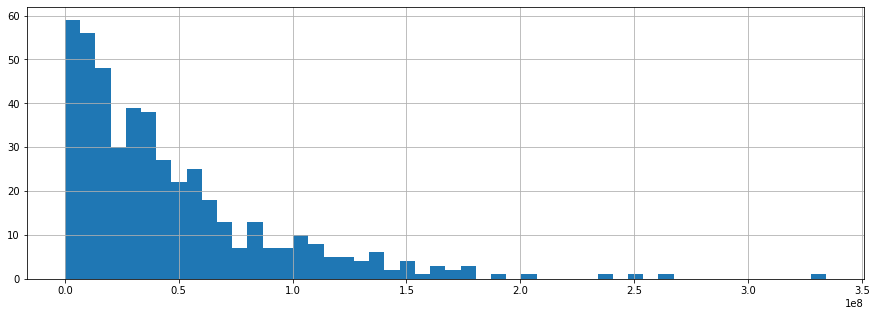

In [150]:
plt.figure(figsize=(15, 5))
titles['boxoffice_us'].hist(bins=50)

In [151]:
# number of boxoffice range
def create_boxoffice_us_bin(data):
    """create bin column for boxoffice_us. values: <1000000, 1000000-5000000, 5000000-10000000, 10000000-50000000, 50000000-100000000, >100000000"""
    data.loc[data['boxoffice_us'] < 1000000, 'boxoffice_us_bin'] = '<1million'
    data.loc[(data['boxoffice_us'] >= 1000000) & (data['boxoffice_us'] < 5000000), 'boxoffice_us_bin'] = '1-5million'
    data.loc[(data['boxoffice_us'] >= 5000000) & (data['boxoffice_us'] < 10000000), 'boxoffice_us_bin'] = '5-10million'
    data.loc[(data['boxoffice_us'] >= 10000000) & (data['boxoffice_us'] < 50000000), 'boxoffice_us_bin'] = '10-50million'
    data.loc[(data['boxoffice_us'] >= 50000000) & (data['boxoffice_us'] < 100000000), 'boxoffice_us_bin'] = '50-100million'
    data.loc[(data['boxoffice_us'] >= 100000000), 'boxoffice_us_bin'] = '>100million'
    
    return data

transactions = create_boxoffice_us_bin(transactions)

def create_num_boxoffice_us_ranges(df, transactions=transactions):
    if 'num_boxoffice_us_ranges' not in df.columns:
        df = pd.merge(df,
                      transactions.groupby(['user_id'])['boxoffice_us_bin'].nunique().reset_index(),
                      on='user_id').rename(columns={'boxoffice_us_bin':'num_boxoffice_us_ranges'})
    
    return df

df = create_num_boxoffice_us_ranges(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption,num_movie_genres,num_trans_comedy,num_trans_music,num_trans_action,num_trans_drama,num_trans_classic,num_trans_thriller,num_trans_sci-fi,num_trans_documentary,num_trans_romantic,num_trans_horror,num_trans_children,num_trans_family,num_trans_crime,num_trans_western,num_trans_suspense,num_trans_war,num_trans_awardwinning,num_trans_adventure,num_trans_musical,num_trans_animation,num_trans_biography,num_trans_fantasy,num_release_year_ranges,num_trans_release_year_1980-1989,num_trans_release_year_1990-1999,num_trans_release_year_2000-2009,num_trans_release_year_2010-2019,num_trans_release_year_<1980,num_boxoffice_us_ranges
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,1,0,3,3.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,4,0,2
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,1
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,2,0,1,8,6.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2,0,1,0,8,0,3
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,0,1
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,4,1,0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,2,3,0,2


In [152]:
# number of transactions in movie boxoffice range 
def create_num_trans_per_boxoffice_us_bin(df):
    num_trans_per_boxoffice_us_bin = pd.pivot_table(transactions,
                                                    index='user_id', 
                                                    values=['transaction_dt'],
                                                    columns=['boxoffice_us_bin'],
                                                    aggfunc=lambda x: len(x),
                                                    fill_value=0).reset_index()
    
    num_trans_per_boxoffice_us_bin.columns = ['num_trans_boxoffice_us_' + str(num_trans_per_boxoffice_us_bin.columns[i][1]).lower()
                                              if (num_trans_per_boxoffice_us_bin.columns[i][1] != '') 
                                              else str(num_trans_per_boxoffice_us_bin.columns[i][0]).lower()
                                              for i in range(len(num_trans_per_boxoffice_us_bin.columns))]
    
    if 'num_trans_boxoffice_us_<1million' not in df.columns:
        df = pd.merge(df,
                      num_trans_per_boxoffice_us_bin,
                      on='user_id')
    
    return df

df = create_num_trans_per_boxoffice_us_bin(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption,num_movie_genres,num_trans_comedy,num_trans_music,num_trans_action,num_trans_drama,num_trans_classic,num_trans_thriller,num_trans_sci-fi,num_trans_documentary,num_trans_romantic,num_trans_horror,num_trans_children,num_trans_family,num_trans_crime,num_trans_western,num_trans_suspense,num_trans_war,num_trans_awardwinning,num_trans_adventure,num_trans_musical,num_trans_animation,num_trans_biography,num_trans_fantasy,num_release_year_ranges,num_trans_release_year_1980-1989,num_trans_release_year_1990-1999,num_trans_release_year_2000-2009,num_trans_release_year_2010-2019,num_trans_release_year_<1980,num_boxoffice_us_ranges,num_trans_boxoffice_us_1-5million,num_trans_boxoffice_us_10-50million,num_trans_boxoffice_us_5-10million,num_trans_boxoffice_us_50-100million,num_trans_boxoffice_us_<1million,num_trans_boxoffice_us_>100million
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,1,0,3,3.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,4,0,2,0,1,0,0,0,3
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,1,0,0,0,0,0,1
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,2,0,1,8,6.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2,0,1,0,8,0,3,0,2,0,4,0,3
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,0,1,0,0,0,0,0,2
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,4,1,0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,2,3,0,2,0,2,0,0,0,3


In [153]:
# number of transactions 0, 1-5, 6-10, >10 years from the release year
def create_years_btwn_trandt_and_release_year(transactions):
    if 'years_btwn_trandt_and_release_year' not in transactions.columns:
        transactions['years_btwn_trandt_and_release_year'] = (transactions['transaction_dt'].dt.year - transactions['release_year']).replace({-1:0}) # assume all releases (digital + physical) are in the same release year
    return transactions

def create_years_btwn_trandt_and_release_year_bin(data):
    """create years_btwn_trandt_and_release_year_bin. values: 0year, 1-5years, 6-10years, >10years"""
    data.loc[data['years_btwn_trandt_and_release_year'] == 0, 'years_btwn_trandt_and_release_year_bin'] = '0year'
    data.loc[(data['years_btwn_trandt_and_release_year'] >= 1) & (data['years_btwn_trandt_and_release_year'] < 6), 'years_btwn_trandt_and_release_year_bin'] = '1-5years'
    data.loc[(data['years_btwn_trandt_and_release_year'] >= 6) & (data['years_btwn_trandt_and_release_year'] < 11), 'years_btwn_trandt_and_release_year_bin'] = '6-10years'
    data.loc[(data['years_btwn_trandt_and_release_year'] >= 11), 'years_btwn_trandt_and_release_year_bin'] = '>10years'
    
    return data

transactions = (transactions
                .pipe(create_years_btwn_trandt_and_release_year)
                .pipe(create_years_btwn_trandt_and_release_year_bin))

def create_num_trans_by_years_btwn_trandt_and_release_year_bin(df, transactions=transactions):
    num_trans_by_years_btwn_trandt_and_release_year_bin = (
         pd.pivot_table(transactions,
                        index='user_id',
                        values=['transaction_dt'],
                        columns=['years_btwn_trandt_and_release_year_bin'], 
                        aggfunc=lambda x: len(x),
                        fill_value=0).reset_index())
    
    num_trans_by_years_btwn_trandt_and_release_year_bin.columns = ['num_trans_' + str(num_trans_by_years_btwn_trandt_and_release_year_bin.columns[i][1] + '_btwn_trandt_and_release_year').lower()
                                              if (num_trans_by_years_btwn_trandt_and_release_year_bin.columns[i][1] != '') 
                                              else str(num_trans_by_years_btwn_trandt_and_release_year_bin.columns[i][0]).lower()
                                              for i in range(len(num_trans_by_years_btwn_trandt_and_release_year_bin.columns))]
        
    if 'num_trans_0year_btwn_trandt_and_release_year' not in df.columns:
        df = pd.merge(df,
                      num_trans_by_years_btwn_trandt_and_release_year_bin,
                      on='user_id')
    
    return df

df = create_num_trans_by_years_btwn_trandt_and_release_year_bin(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption,num_movie_genres,num_trans_comedy,num_trans_music,num_trans_action,num_trans_drama,num_trans_classic,num_trans_thriller,num_trans_sci-fi,num_trans_documentary,num_trans_romantic,num_trans_horror,num_trans_children,num_trans_family,num_trans_crime,num_trans_western,num_trans_suspense,num_trans_war,num_trans_awardwinning,num_trans_adventure,num_trans_musical,num_trans_animation,num_trans_biography,num_trans_fantasy,num_release_year_ranges,num_trans_release_year_1980-1989,num_trans_release_year_1990-1999,num_trans_release_year_2000-2009,num_trans_release_year_2010-2019,num_trans_release_year_<1980,num_boxoffice_us_ranges,num_trans_boxoffice_us_1-5million,num_trans_boxoffice_us_10-50million,num_trans_boxoffice_us_5-10million,num_trans_boxoffice_us_50-100million,num_trans_boxoffice_us_<1million,num_trans_boxoffice_us_>100million,num_trans_0year_btwn_trandt_and_release_year,num_trans_1-5years_btwn_trandt_and_release_year,num_trans_6-10years_btwn_trandt_and_release_year,num_trans_>10years_btwn_trandt_and_release_year
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,1,0,3,3.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,4,0,2,0,1,0,0,0,3,1,3,0,0
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,2,0,1,8,6.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2,0,1,0,8,0,3,0,2,0,4,0,3,2,5,1,1
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,0,1,0,0,0,0,0,2,0,2,0,0
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,4,1,0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,2,3,0,2,0,2,0,0,0,3,0,3,0,2


In [154]:
# max number of purchase on a single movie
def create_max_num_trans_for_a_movie(df, transactions=transactions):
    if 'max_num_trans_for_a_movie' not in df.columns:
        df = pd.merge(df,
                      (transactions
                       .groupby(['user_id', 'title_eidr'])['transaction_dt'].count().reset_index()
                       .groupby(['user_id'])['transaction_dt'].max().reset_index()),
                      on='user_id').rename(columns={'transaction_dt': 'max_num_trans_for_a_movie'})
    return df

df = create_max_num_trans_for_a_movie(df)
df.head()

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption,num_movie_genres,num_trans_comedy,num_trans_music,num_trans_action,num_trans_drama,num_trans_classic,num_trans_thriller,num_trans_sci-fi,num_trans_documentary,num_trans_romantic,num_trans_horror,num_trans_children,num_trans_family,num_trans_crime,num_trans_western,num_trans_suspense,num_trans_war,num_trans_awardwinning,num_trans_adventure,num_trans_musical,num_trans_animation,num_trans_biography,num_trans_fantasy,num_release_year_ranges,num_trans_release_year_1980-1989,num_trans_release_year_1990-1999,num_trans_release_year_2000-2009,num_trans_release_year_2010-2019,num_trans_release_year_<1980,num_boxoffice_us_ranges,num_trans_boxoffice_us_1-5million,num_trans_boxoffice_us_10-50million,num_trans_boxoffice_us_5-10million,num_trans_boxoffice_us_50-100million,num_trans_boxoffice_us_<1million,num_trans_boxoffice_us_>100million,num_trans_0year_btwn_trandt_and_release_year,num_trans_1-5years_btwn_trandt_and_release_year,num_trans_6-10years_btwn_trandt_and_release_year,num_trans_>10years_btwn_trandt_and_release_year,max_num_trans_for_a_movie
0,680,602,196,4,1.0,1.0,0.0,0.0,1.0,1.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,1,0,3,3.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,4,0,2,0,1,0,0,0,3,1,3,0,0,1
1,1016,795,736,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1
2,2314,631,113,9,6.0,0.0,0.0,1.0,0.0,2.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,2,0,1,8,6.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2,0,1,0,8,0,3,0,2,0,4,0,3,2,5,1,1,1
3,2472,774,598,2,0.0,0.0,0.0,0.0,1.0,1.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,0,1,0,0,0,0,0,2,0,2,0,0,1
4,2673,748,267,5,0.0,0.0,0.0,0.0,1.0,4.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,4,1,0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,2,3,0,2,0,2,0,0,0,3,0,3,0,2,2


### 2.2 Users Segmentation 

In [155]:
df_copy = df.copy()

#### Analysis 5: Recency, Frequency

In [156]:
recency = df[['user_id', 'days_btwn_lst_trandt_and_oct2019']]
frequency = df[['user_id', 'num_transactions']]
frequency = (pd.merge(frequency,
                      (transactions
                       .groupby(['user_id'])['transaction_dt'].min()
                       .reset_index()
                       .rename(columns={'transaction_dt':'1st_trans_dt'})),
                      on='user_id'))
frequency['num_trans_per_day'] = pd.Series(frequency['num_transactions'] / (pd.to_datetime('10-01-2019') - frequency['1st_trans_dt']).dt.days)
rf = pd.merge(recency,
              frequency[['user_id', 'num_trans_per_day']],
              on='user_id').rename(columns={'days_btwn_lst_trandt_and_oct2019':'R', 'num_trans_per_day':'F'})
rf['R'] = pd.qcut(rf['R'], q=3, labels=[3, 2, 1]).astype(int)
rf['F'] = pd.qcut(rf['F'], q=3, labels=[1, 2, 3]).astype(int)
rf['RF'] = rf['R'] + rf['F']
rf

,user_id,R,F,RF
0,680,3,3,6
1,1016,1,1,2
2,2314,3,3,6
3,2472,2,2,4
4,2673,3,3,6
...,...,...,...,...
8873,49552348,3,3,6
8874,49552619,1,2,3
8875,49553040,3,3,6
8876,49553585,1,1,2


In [157]:
rf[['R', 'F']].value_counts().reset_index().rename(columns={0:'freq'}).sort_values(by=['R', 'F'], ascending=False)

,R,F,freq
1,3,3,2095
4,3,2,771
8,3,1,94
5,2,3,572
2,2,2,1624
3,2,1,771
7,1,3,292
6,1,2,545
0,1,1,2114


In [158]:
rf[['RF']].value_counts().reset_index().rename(columns={0:'freq'}).sort_values(by=['RF'], ascending=False)

,RF,freq
1,6,2095
3,5,1343
2,4,2010
4,3,1316
0,2,2114


In [159]:
# normalization
norm = Normalizer()
df = df.drop(columns=['clusters'], errors='ignore')
df_norm = pd.DataFrame(norm.fit_transform(df.set_index('user_id')), columns=df.columns[1:])

#### 2.2.1 Elbow Method

In [160]:
ssd = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_norm)
    ssd.append(kmeans.inertia_)

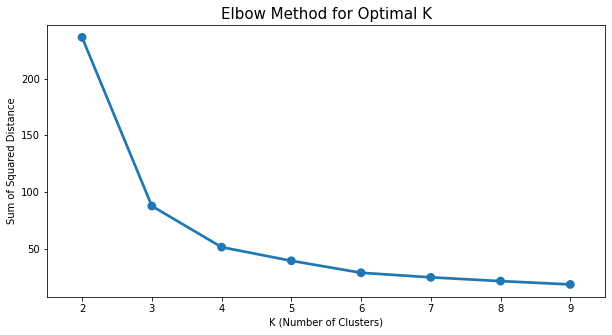

In [161]:
plt.figure(figsize=(10, 5))
plt.title('Elbow Method for Optimal K', fontsize=15)
sns.pointplot(x=np.arange(2, 10), y=ssd)
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Sum of Squared Distance')
plt.savefig('elbow_method.jpg', dpi=200, bbox_inches='tight');

In [162]:
k4 = KMeans(n_clusters=4, max_iter=500, random_state=42)
clusters = k4.fit_predict(df_norm)
df['clusters'] = pd.Series(clusters)
df_norm['clusters'] = pd.Series(clusters)

In [163]:
df_norm.head()

,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption,num_movie_genres,num_trans_comedy,num_trans_music,num_trans_action,num_trans_drama,num_trans_classic,num_trans_thriller,num_trans_sci-fi,num_trans_documentary,num_trans_romantic,num_trans_horror,num_trans_children,num_trans_family,num_trans_crime,num_trans_western,num_trans_suspense,num_trans_war,num_trans_awardwinning,num_trans_adventure,num_trans_musical,num_trans_animation,num_trans_biography,num_trans_fantasy,num_release_year_ranges,num_trans_release_year_1980-1989,num_trans_release_year_1990-1999,num_trans_release_year_2000-2009,num_trans_release_year_2010-2019,num_trans_release_year_<1980,num_boxoffice_us_ranges,num_trans_boxoffice_us_1-5million,num_trans_boxoffice_us_10-50million,num_trans_boxoffice_us_5-10million,num_trans_boxoffice_us_50-100million,num_trans_boxoffice_us_<1million,num_trans_boxoffice_us_>100million,num_trans_0year_btwn_trandt_and_release_year,num_trans_1-5years_btwn_trandt_and_release_year,num_trans_6-10years_btwn_trandt_and_release_year,num_trans_>10years_btwn_trandt_and_release_year,max_num_trans_for_a_movie,clusters
0,0.950726,0.309539,0.006317,0.001579,0.001579,0.0,0.000000,0.001579,0.001579,0.006317,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.006317,0.0,0.0,0.0,0.003159,0.001579,0.000000,0.004738,0.004738,0.003159,0.0,0.001579,0.001579,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001579,0.0,0.000000,0.000000,0.006317,0.0,0.003159,0.0,0.001579,0.0,0.000000,0.0,0.004738,0.001579,0.004738,0.000000,0.000000,0.001579,3
1,0.733807,0.679349,0.000923,0.000000,0.000000,0.0,0.000923,0.000000,0.000000,0.000923,0.000000,0.0,0.0,0.0,0.0,0.0,0.000923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000923,0.000000,0.000923,0.000000,0.000923,0.000923,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000923,0.0,0.000000,0.000000,0.000923,0.0,0.000923,0.0,0.000000,0.0,0.000000,0.0,0.000923,0.000000,0.000923,0.000000,0.000000,0.000923,0
2,0.983672,0.176157,0.014030,0.009353,0.000000,0.0,0.001559,0.000000,0.003118,0.014030,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.014030,0.0,0.0,0.0,0.003118,0.000000,0.001559,0.012471,0.009353,0.003118,0.0,0.003118,0.001559,0.0,0.0,0.0,0.0,0.0,0.0,0.004677,0.004677,0.0,0.0,0.0,0.0,0.0,0.003118,0.0,0.0,0.0,0.0,0.003118,0.0,0.001559,0.000000,0.012471,0.0,0.004677,0.0,0.003118,0.0,0.006236,0.0,0.004677,0.003118,0.007795,0.001559,0.001559,0.001559,1
3,0.791313,0.611376,0.002045,0.000000,0.000000,0.0,0.000000,0.001022,0.001022,0.002045,0.002045,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.002045,0.000000,0.001022,0.001022,0.002045,0.001022,0.0,0.001022,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001022,0.0,0.000000,0.000000,0.002045,0.0,0.001022,0.0,0.000000,0.0,0.000000,0.0,0.002045,0.000000,0.002045,0.000000,0.000000,0.001022,0
4,0.941676,0.336133,0.006295,0.000000,0.000000,0.0,0.000000,0.001259,0.005036,0.003777,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006295,0.000000,0.0,0.0,0.0,0.002518,0.005036,0.001259,0.000000,0.002518,0.003777,0.0,0.002518,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,

#### Interpretability

In [164]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
    inner_tree: _tree.Tree = tree.tree_
    classes = tree.classes_
    class_rules_dict = dict()

    def tree_dfs(node_id=0, current_rule=[]):
        # feature[i] holds the feature to split on, for the internal node i.
        split_feature = inner_tree.feature[node_id]
        if split_feature != _tree.TREE_UNDEFINED: # internal node
            name = feature_names[split_feature]
            threshold = inner_tree.threshold[node_id]
            # left child
            left_rule = current_rule + ["({} <= {})".format(name, threshold)]
            tree_dfs(inner_tree.children_left[node_id], left_rule)
            # right child
            right_rule = current_rule + ["({} > {})".format(name, threshold)]
            tree_dfs(inner_tree.children_right[node_id], right_rule)
        else: # leaf
            dist = inner_tree.value[node_id][0]
            dist = dist/dist.sum()
            max_idx = dist.argmax()
            if len(current_rule) == 0:
                rule_string = "ALL"
            else:
                rule_string = " and ".join(current_rule)
            # register new rule to dictionary
            selected_class = classes[max_idx]
            class_probability = dist[max_idx]
            class_rules = class_rules_dict.get(selected_class, [])
            class_rules.append((rule_string, class_probability))
            class_rules_dict[selected_class] = class_rules
    
    tree_dfs() # start from root, node_id = 0
    return class_rules_dict

def cluster_report(data, clusters, max_depth = 5, min_samples_leaf=50, pruning_level=0.01, figsize=(15, 15), fontsize=5):
    # create a decision tree
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, 
                                  max_depth=max_depth, 
                                  ccp_alpha=pruning_level, 
                                  random_state=42
                                 )
    tree.fit(data, clusters)
    
    plt.figure(figsize=figsize)
    plot_tree(tree, 
              # max_depth=max_depth, 
              fontsize=fontsize, 
              filled=True, 
              feature_names=data.columns, 
              class_names=['cluster0', 'cluster1', 'cluster2', 'cluster3'])
    plt.savefig('tree-decision.jpg', dpi=100)
    plt.show()
    
    # generate decision report 
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['cluster', 'num_users']
    report_df = pd.DataFrame(report_class_list, columns=['cluster', 'decision_process'])
    report_df = pd.merge(cluster_instance_df, report_df, on='cluster', how='left')
    pretty_print(report_df.sort_values(by='cluster')[['cluster', 'num_users', 'decision_process']])

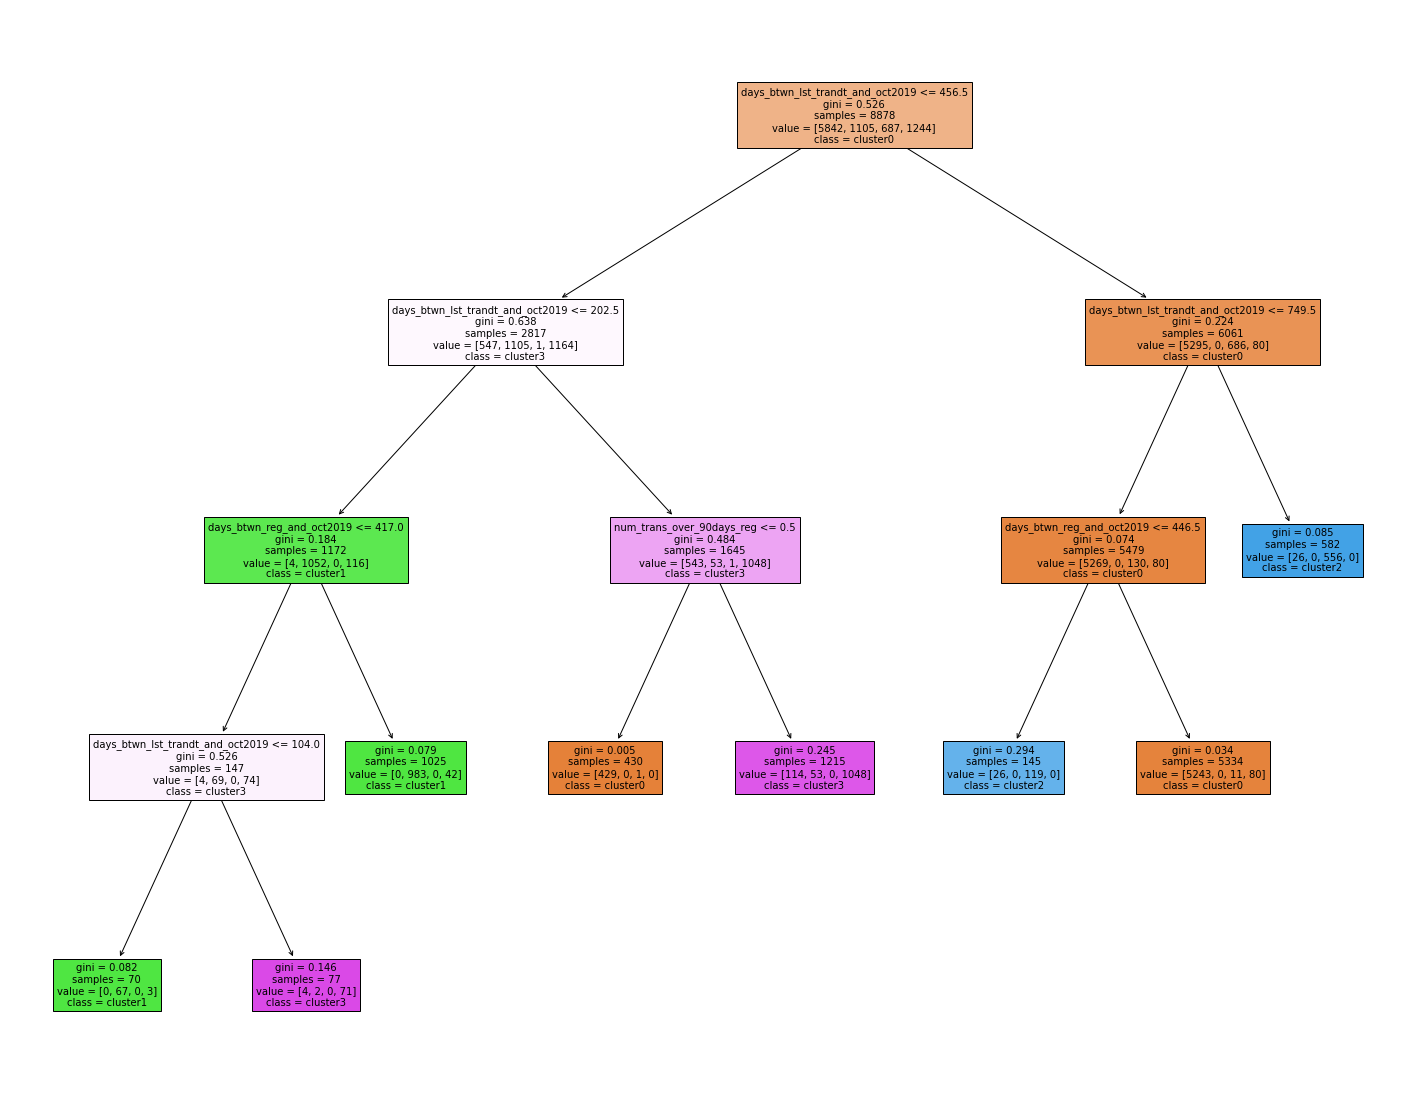

,cluster,num_users,decision_process
0,0,5842,[0.9976744186046511] (days_btwn_lst_trandt_and_oct2019 <= 456.5) and (days_btwn_lst_trandt_and_oct2019 > 202.5) and (num_trans_over_90days_reg <= 0.5)[0.9829396325459318] (days_btwn_lst_trandt_and_oct2019 > 456.5) and (days_btwn_lst_trandt_and_oct2019 <= 749.5) and (days_btwn_reg_and_oct2019 > 446.5)
2,1,1105,[0.9571428571428572] (days_btwn_lst_trandt_and_oct2019 <= 456.5) and (days_btwn_lst_trandt_and_oct2019 <= 202.5) and (days_btwn_reg_and_oct2019 <= 417.0) and (days_btwn_lst_trandt_and_oct2019 <= 104.0)[0.9590243902439024] (days_btwn_lst_trandt_and_oct2019 <= 456.5) and (days_btwn_lst_trandt_and_oct2019 <= 202.5) and (days_btwn_reg_and_oct2019 > 417.0)
3,2,687,[0.8206896551724138] (days_btwn_lst_trandt_and_oct2019 > 456.5) and (days_btwn_lst_trandt_and_oct2019 <= 749.5) and (days_btwn_reg_and_oct2019 <= 446.5)[0.9553264604810997] (days_btwn_lst_trandt_and_oct2019 > 456.5) and (days_btwn_lst_trandt_and_oct2019 > 749.5)
1,3,1244,[0.922077922077922] (days_btwn_lst_trandt_and_oct2019 <= 456.5) and (days_btwn_lst_trandt_and_oct2019 <= 202.5) and (days_btwn_reg_and_oct2019 <= 417.0) and (days_btwn_lst_trandt_and_oct2019 > 104.0)[0.8625514403292182] (days_btwn_lst_trandt_and_oct2019 <= 456.5) and (days_btwn_lst_trandt_and_oct2019 > 202.5) and (num_trans_over_90days_reg > 0.5)


In [165]:
cluster_report(
    df.set_index('user_id').iloc[:, :-1], 
    df['clusters'], 
    max_depth=4, 
    min_samples_leaf=50, 
    pruning_level=0.005, 
    figsize=(25, 20), 
    fontsize=10
)

### User Groups (calculation based on Oct 1st, 2019)
- **Cluster3 (1105 Highly Active Users)**
    - users who has the most recent purchase for less than 104 days ago from Oct, 2019 and has registered for less than 417 days from Oct, 2019
    - users who has the most recent purchase for less than 203 days ago from Oct, 2019 and has registered for more than 417 days from Oct, 2019
- **Cluster1 （1244 Active Users）**
    - users who has the most recent purchase between 104 and 203 days ago from Oct, 2019 and has registered for less than 417 days from Oct, 2019
    - users who has the most recent purchase between 203 and 457 days ago from Oct, 2019 and has at least one purchase after 90 days from registration
- **Cluster0 (5842 Inactive Users)**
    - users who has the most recent purchase between 203 and 457 days ago from Oct, 2019 and has no purchase after 90 days from registration
    - users who has the most recent purchase between 457 and 750 days ago from Oct, 2019 and has registered for more than 447 days from Oct, 2019
- **Cluster2 (687 Churned Users)**
    - users who has the most recent purchase between 457 and 750 days ago from Oct, 2019 and has registered for less than 447 days from Oct, 2019
    - users who has the most recent purchase for more than 750 days ago from Oct, 2019

In [166]:
if 'clusters' not in rf.columns:
    rf = pd.merge(rf,
                  df[['user_id', 'clusters']],
                  on='user_id')
    rf['clusters'] = rf['clusters'].replace({0:'Inactive', 1:'Active', 2:'Churned', 3:'Highly Active'})

In [167]:
rf

,user_id,R,F,RF,clusters
0,680,3,3,6,Highly Active
1,1016,1,1,2,Inactive
2,2314,3,3,6,Active
3,2472,2,2,4,Inactive
4,2673,3,3,6,Highly Active
...,...,...,...,...,...
8873,49552348,3,3,6,Highly Active
8874,49552619,1,2,3,Churned
8875,49553040,3,3,6,Inactive
8876,49553585,1,1,2,Churned


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  """


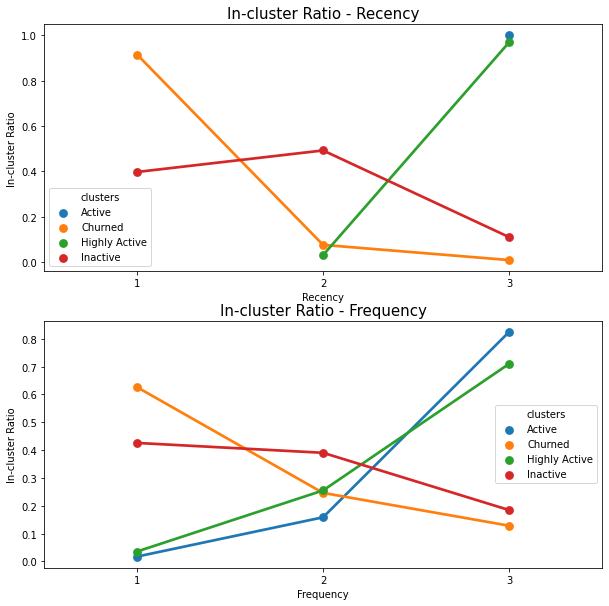

In [168]:
r_plot = pd.DataFrame(rf.groupby(['clusters'])['R'].value_counts(normalize=True)).rename(columns={'R':'In-cluster Ratio'}).reset_index()
f_plot = pd.DataFrame(rf.groupby(['clusters'])['F'].value_counts(normalize=True)).rename(columns={'F':'In-cluster Ratio'}).reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
fig.tight_layout(rect=[0, 5, 5, 0])
sns.pointplot(data=r_plot, x='R', y='In-cluster Ratio', hue='clusters', ax=ax1)
ax1.set_xlabel('Recency')
ax1.set_title('In-cluster Ratio - Recency', fontsize=15)

sns.pointplot(data=f_plot, x='F', y='In-cluster Ratio', hue='clusters', ax=ax2)
ax2.set_title('In-cluster Ratio - Frequency', fontsize=15)
ax2.set_xlabel('Frequency')
plt.savefig('RF.jpg', dpi=200);

In [169]:
rf['order'] = rf['clusters'].replace({'Highly Active':1, 'Active':2, 'Inactive':3, 'Churned':4})
rf = rf.sort_values(['order']).reset_index(drop=True)

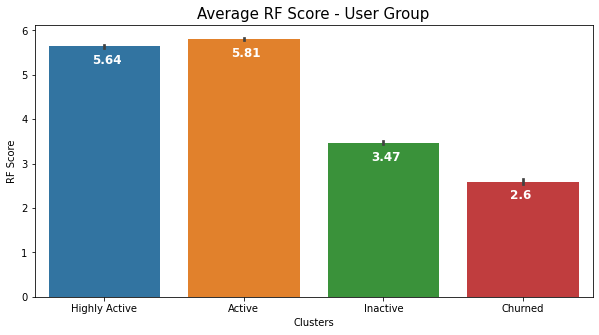

In [170]:
plt.figure(figsize=(10, 5))
plt.title('Average RF Score - User Group', fontsize=15)
sns.barplot(data=rf, x='clusters', y='RF')
mean_rf_list = rf.groupby(['order'])['RF'].mean().apply(lambda x: np.round(x, 2)).tolist()
for i in plt.xticks()[0]:
    plt.text(x=i-0.09, y=mean_rf_list[i] - 0.4, s=str(mean_rf_list[i]), fontsize='large', family='fantasy', color='white', fontweight='bold')
plt.xlabel('Clusters')
plt.ylabel('RF Score')
plt.savefig('rf_score.jpg', bbox_inches='tight', dpi=300);

#### Important factors are **Recency**, **Registration Length**, and **After-90-days Purchase**.
##### From **Highly Active Users** to **High Value Users**

In [171]:
print('Highly Active User Rate = {:.2%}'.format((1105)/8849))
print('Active User Rate = {:.2%}'.format((1244 + 1105)/8849))
print('Inactive User Rate = {:.2%}'.format(5842/8849))

Highly Active User Rate = 12.49%
Active User Rate = 26.55%
Inactive User Rate = 66.02%


### 2.3 Highly Active Users: Understand Preferences with Classification

In [172]:
preference_col_list = []
for cat in feature_categories.keys():
    if 'preference' in cat:
        preference_col_list.extend(feature_categories[cat])

df_c = (df
        .set_index('user_id')
        .drop(columns=['days_btwn_reg_and_oct2019', 
                       'days_btwn_lst_trandt_and_oct2019', 
                       'num_trans_over_90days_reg'])
        [preference_col_list + ['clusters']] # here we only consider preference
       )
df_c = df_c.rename(columns={'clusters': 'is_highly_active_ind'})
df_c['is_highly_active_ind'] = df_c['is_highly_active_ind'].apply(lambda x: 1 if x == 3 else 0)
df_c.head()

,num_trans_comedy,num_trans_music,num_trans_action,num_trans_drama,num_trans_classic,num_trans_thriller,num_trans_sci-fi,num_trans_documentary,num_trans_romantic,num_trans_horror,num_trans_children,num_trans_family,num_trans_crime,num_trans_western,num_trans_suspense,num_trans_war,num_trans_awardwinning,num_trans_adventure,num_trans_musical,num_trans_animation,num_trans_biography,num_trans_fantasy,num_release_year_ranges,num_trans_release_year_1980-1989,num_trans_release_year_1990-1999,num_trans_release_year_2000-2009,num_trans_release_year_2010-2019,num_trans_release_year_<1980,num_boxoffice_us_ranges,num_trans_boxoffice_us_1-5million,num_trans_boxoffice_us_10-50million,num_trans_boxoffice_us_5-10million,num_trans_boxoffice_us_50-100million,num_trans_boxoffice_us_<1million,num_trans_boxoffice_us_>100million,num_trans_0year_btwn_trandt_and_release_year,num_trans_1-5years_btwn_trandt_and_release_year,num_trans_6-10years_btwn_trandt_and_release_year,num_trans_>10years_btwn_trandt_and_release_year,max_num_trans_for_a_movie,is_highly_active_ind
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
680,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,4,0,2,0,1,0,0,0,3,1,3,0,0,1,1
1016,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0
2314,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2,0,1,0,8,0,3,0,2,0,4,0,3,2,5,1,1,1,0
2472,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,0,1,0,0,0,0,0,2,0,2,0,0,1,0
2673,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,2,3,0,2,0,2,0,0,0,3,0,3,0,2,2,1


In [173]:
X_train, X_test, y_train, y_test = train_test_split(df_c.drop(columns=['is_highly_active_ind']), 
                                                    df_c['is_highly_active_ind'], 
                                                    test_size=0.7, 
                                                    random_state=42)

In [174]:
gbc = GradientBoostingClassifier(max_features='auto', n_estimators=50)
gbc.fit(X_train, y_train)
print('ROC-AUC = {:.2%}'.format(roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1]))) # ROC-AUC is threshold insensitive 

ROC-AUC = 77.19%


In [175]:
def create_col_category(data, mapping_dict):
    """create a column to categorize features."""
    for col in data['col_name'].tolist():
        items = list(mapping_dict.items())
        for i, item in enumerate(items):
            if col in item[1]:
                data.loc[lambda x: x['col_name'] == col, 'category'] = item[0]
    
    return data 

In [176]:
feature_importance =pd.DataFrame(np.array([df_c.drop(columns=['is_highly_active_ind']).columns.tolist(), gbc.feature_importances_.T]).T, columns=['col_name', 'feature_importance'])

feature_importance['feature_importance'] = feature_importance['feature_importance'].apply(lambda x: np.round(np.float(x), 5))
feature_importance = create_col_category(feature_importance, feature_categories)

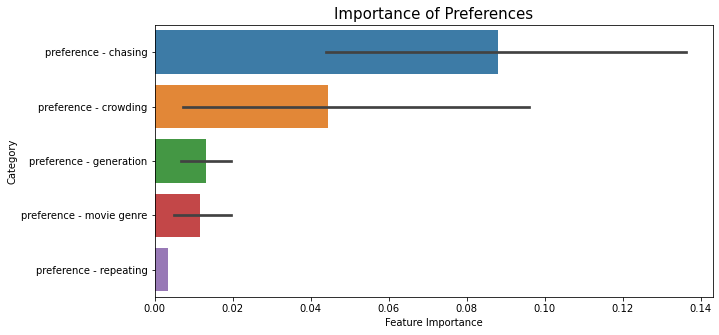

In [177]:
plt.figure(figsize=(10, 5))
plt.title('Importance of Preferences', fontsize=15)
sns.barplot(data=feature_importance
            .sort_values(by=['category'], ascending=True), 
            x='feature_importance', 
            y='category',
           alpha=0.95)
plt.xlabel('Feature Importance')
plt.ylabel('Category')
plt.savefig('highly_performance_user_preferences.jpg', dpi=200, bbox_inches='tight')

In [178]:
def create_action_list(feature_importance, num_actions_per_cat=1):
    
    action_list = (feature_importance
                .sort_values(by=['category', 'feature_importance'], ascending=[True, False])
                .groupby(['category']).apply(lambda x: x[['col_name', 'feature_importance']].reset_index(drop=True).iloc[:num_actions_per_cat])
                .reset_index()
                .drop(columns=['level_1'], errors='ignore')) 
    
    return action_list

action_list = create_action_list(feature_importance, num_actions_per_cat=3)
action_list.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True), subset=['feature_importance'])

,category,col_name,feature_importance
0,preference - chasing,num_trans_1-5years_btwn_trandt_and_release_year,0.166340
1,preference - chasing,num_trans_>10years_btwn_trandt_and_release_year,0.097720
2,preference - chasing,num_trans_0year_btwn_trandt_and_release_year,0.045980
3,preference - crowding,num_trans_boxoffice_us_>100million,0.198680
4,preference - crowding,num_trans_boxoffice_us_50-100million,0.063810
5,preference - crowding,num_trans_boxoffice_us_10-50million,0.028410
6,preference - generation,num_trans_release_year_1990-1999,0.024930
7,preference - generation,num_trans_release_year_1980-1989,0.021290
8,preference - generation,num_trans_release_year_2000-2009,0.012480
9,preference - movie genre,num_trans_action,0.065190


In [179]:
# get the highly asctive user representative
def get_incluster_representative_user(df, df_norm, cluster_number):
    distance_table = df_norm.copy()
    
    for i in range(4):
        c_centroid = k4.cluster_centers_[i]
        c_users = df_norm.loc[df_norm['clusters'] == i].drop(columns=['clusters'])
        _, dists = pairwise_distances_argmin_min(X=c_users, Y=np.array([c_centroid] * len(c_users))) # distance calculation is df index sensitive, here user_id must not be used as index
        distance_table.loc[distance_table['clusters'] == i, 'dist_from_cluster_controid_' + str(i)] = dists
    
    distance_table = pd.concat([df[['user_id']], distance_table], axis=1)
    col_name = 'dist_from_cluster_controid_' + str(cluster_number) 
    
    return df.loc[df['user_id'] == distance_table.loc[distance_table[col_name] == distance_table[col_name].min()]['user_id'].values[0]]

rep_hau = get_incluster_representative_user(df, df_norm, cluster_number=3)
rep_hau[['user_id'] + action_list['col_name'].tolist()]

,user_id,num_trans_1-5years_btwn_trandt_and_release_year,num_trans_>10years_btwn_trandt_and_release_year,num_trans_0year_btwn_trandt_and_release_year,num_trans_boxoffice_us_>100million,num_trans_boxoffice_us_50-100million,num_trans_boxoffice_us_10-50million,num_trans_release_year_1990-1999,num_trans_release_year_1980-1989,num_trans_release_year_2000-2009,num_trans_action,num_trans_comedy,num_trans_horror,max_num_trans_for_a_movie
5359,1804132,4,0,0,4,1,1,0,0,2,1.0,3.0,0.0,1


In [193]:
users.loc[users['user_id'] == 1804132]

,user_id,registration_date,dominant_client_type
5360,1804132,2017-12-14,WEB


In [180]:
rep_hau

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption,num_movie_genres,num_trans_comedy,num_trans_music,num_trans_action,num_trans_drama,num_trans_classic,num_trans_thriller,num_trans_sci-fi,num_trans_documentary,num_trans_romantic,num_trans_horror,num_trans_children,num_trans_family,num_trans_crime,num_trans_western,num_trans_suspense,num_trans_war,num_trans_awardwinning,num_trans_adventure,num_trans_musical,num_trans_animation,num_trans_biography,num_trans_fantasy,num_release_year_ranges,num_trans_release_year_1980-1989,num_trans_release_year_1990-1999,num_trans_release_year_2000-2009,num_trans_release_year_2010-2019,num_trans_release_year_<1980,num_boxoffice_us_ranges,num_trans_boxoffice_us_1-5million,num_trans_boxoffice_us_10-50million,num_trans_boxoffice_us_5-10million,num_trans_boxoffice_us_50-100million,num_trans_boxoffice_us_<1million,num_trans_boxoffice_us_>100million,num_trans_0year_btwn_trandt_and_release_year,num_trans_1-5years_btwn_trandt_and_release_year,num_trans_6-10years_btwn_trandt_and_release_year,num_trans_>10years_btwn_trandt_and_release_year,max_num_trans_for_a_movie,clusters
5359,1804132,656,307,6,2.0,0.0,0.0,1.0,0.0,3.0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,3,2,1,3,5.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,0,0,2,4,0,3,0,1,0,1,0,4,0,4,2,0,1,3


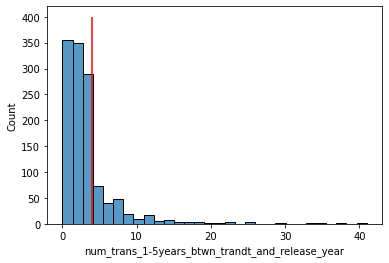

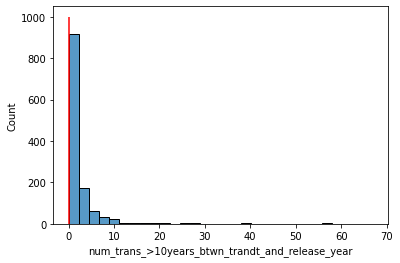

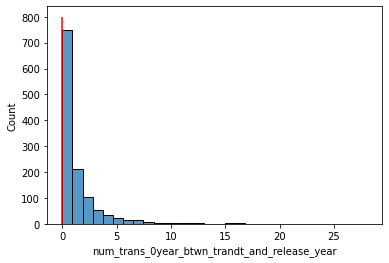

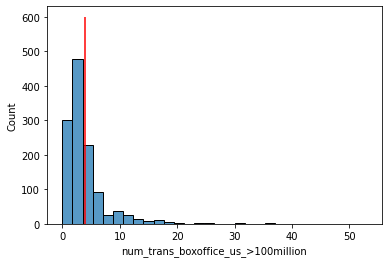

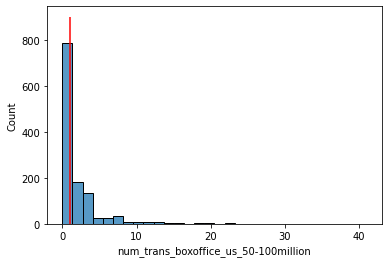

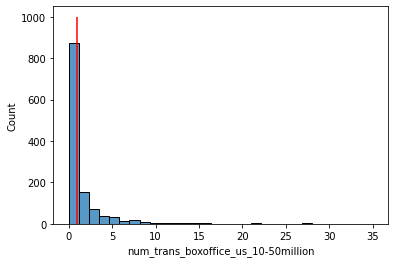

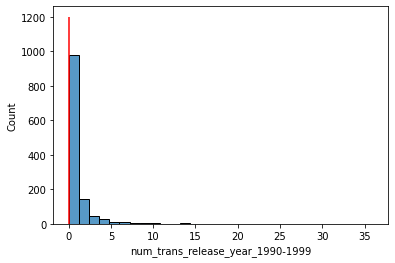

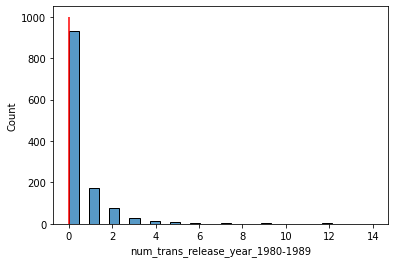

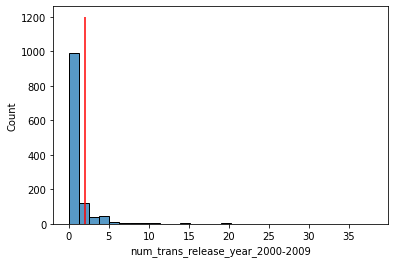

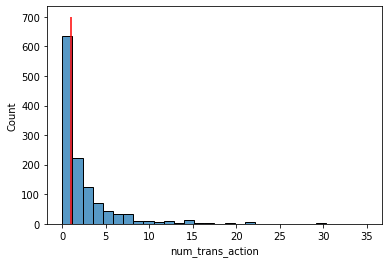

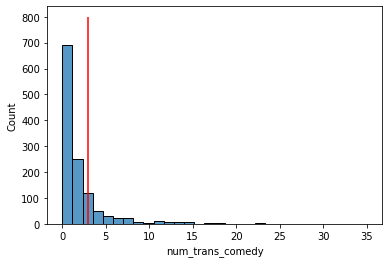

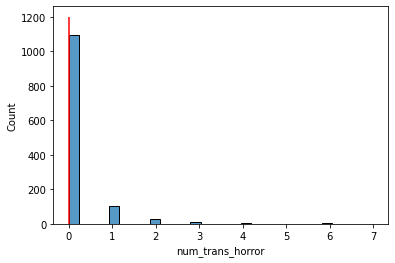

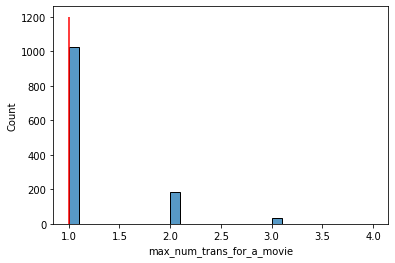

In [181]:
def plot_incluster_action_list_histograms(df, col_list, cluster_number, savefig_prefix='', cluster_number_list = None, rep_user=None):

    for col in col_list:
        plt.figure()
        if cluster_number_list is not None:
            sns.histplot(df.loc[df['clusters'].isin(cluster_number_list)][col], bins=30)
        else:
            sns.histplot(df.loc[df['clusters'] == cluster_number][col], bins=30)
        if rep_user is not None:
            plt.vlines(x=rep_user[col].values[0], ymin=0, ymax=plt.yticks()[0][-1], colors='red')
        plt.savefig(savefig_prefix + str(col) + '.jpg', bbox_inches='tight', dpi=200)
        plt.show()
        
plot_incluster_action_list_histograms(df, col_list=action_list['col_name'], cluster_number=3, rep_user=rep_hau, savefig_prefix='highly_active_user_')

### Takeways:
   - Importance: Chasing > Crowding > Generation > Genre
   - Proposed Actions on The Preference & Taste:
       1. Recommend ✔️
           - new releases, e.g. under 5 years
           - has over 100 million us boxoffice
           - are somewhat old, e.g. has been released for more than 10 years, or typically in the 80's
           - but not old, e.g. before 80's
           - are actions, adventures
           - more variaties of genre
       2. Do not recommend ❌
           - not domestically popular or known, e.g. movies with 10-50 millions us boxoffice
           - watched movies

### 2.4 Churn Users: Understand Potential Reasons of Churn with Classification

#### According to the above clustering analysis, churned users usually haven't purchased for more than 457days, which is around 15month. 
#### Churn: users having no purchase for more than 457days

In [182]:
df_churn = df.set_index('user_id')
df_churn['is_churn'] = df_churn['days_btwn_lst_trandt_and_oct2019'].apply(lambda x: 1 if x > 457 else 0)
df_churn = df_churn.drop(columns=['days_btwn_lst_trandt_and_oct2019', 'clusters'])[feature_categories['journey'] + 
                                                                                   feature_categories['device type'] + 
                                                                                   feature_categories['transaction type'] + 
                                                                                   feature_categories['preference - repeating'] +
                                                                                   ['is_churn']]

In [183]:
print('Churn Rate = {:.2%}'.format(df_churn['is_churn'].mean()))

Churn Rate = 68.17%


In [184]:
X_train, X_test, y_train, y_test = train_test_split(df_churn.drop(columns=['is_churn']), 
                                                    df_churn['is_churn'], 
                                                    test_size=0.8, 
                                                    random_state=42)

In [185]:
gbc = GradientBoostingClassifier(max_features='auto')
gbc.fit(X_train, y_train)
print('ROC-AUC = {:.2%}'.format(roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])))

ROC-AUC = 97.83%


In [186]:
feature_importance =pd.DataFrame(np.array([df_churn.drop(columns=['is_churn']).columns.tolist(), gbc.feature_importances_.T]).T, columns=['col_name', 'feature_importance'])
feature_importance['feature_importance'] = feature_importance['feature_importance'].apply(lambda x: np.round(np.float(x), 5))
feature_importance = create_col_category(feature_importance, feature_categories)

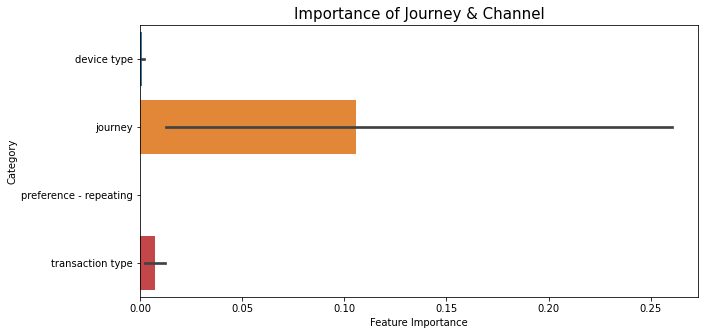

In [187]:
plt.figure(figsize=(10, 5))
plt.title('Importance of Journey & Channel', fontsize=15)
sns.barplot(data=feature_importance
            .sort_values(by=['category'], ascending=True), 
            x='feature_importance', 
            y='category',
           alpha=0.95)
plt.xlabel('Feature Importance')
plt.ylabel('Category')
plt.savefig('churned_user_journey_channel.jpg', bbox_inches='tight', dpi=300);

In [188]:
action_list = create_action_list(feature_importance, num_actions_per_cat=3)
action_list.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True), subset=['feature_importance'])

,category,col_name,feature_importance
0,device type,num_trans_android,0.007790
1,device type,num_trans_fire_tv,0.003010
2,device type,num_trans_ios,0.001740
3,journey,num_trans_over_90days_reg,0.657410
4,journey,days_btwn_reg_and_oct2019,0.173120
5,journey,num_trans_before_reg,0.044810
6,preference - repeating,max_num_trans_for_a_movie,0.000000
7,transaction type,num_trans_redemption,0.013940
8,transaction type,num_trans_est,0.010330
9,transaction type,num_trans_free_movie,0.002970


In [189]:
users.loc[users['user_id'] == 42186522]

,user_id,registration_date,dominant_client_type
8237,42186522,2018-01-16,IOS


In [190]:
rep_cu = get_incluster_representative_user(df, df_norm, cluster_number=2)
rep_cu[['user_id'] + action_list['col_name'].tolist()]

,user_id,num_trans_android,num_trans_fire_tv,num_trans_ios,num_trans_over_90days_reg,days_btwn_reg_and_oct2019,num_trans_before_reg,max_num_trans_for_a_movie,num_trans_redemption,num_trans_est,num_trans_free_movie
8236,42186522,0,0,3,0.0,623,3.0,1,3,0,0


In [191]:
rep_cu

,user_id,days_btwn_reg_and_oct2019,days_btwn_lst_trandt_and_oct2019,num_transactions,num_trans_before_reg,num_trans_on_reg,num_trans_within_30_days_reg,num_trans_30_to_60_days_reg,num_trans_60_to_90_days_reg,num_trans_over_90days_reg,num_movies,num_trans_android,num_trans_android/android,num_trans_android/ios,num_trans_android/roku,num_trans_android_tv,num_trans_android_tv/ios,num_trans_fire_tv,num_trans_ios,num_trans_ios/android,num_trans_ios/web,num_trans_kindle,num_trans_na,num_trans_ps4,num_trans_roku,num_trans_tv_os,num_trans_web,num_trans_web/android,num_trans_web/ios,num_trans_web/web,num_transaction_types,num_trans_est,num_trans_free_movie,num_trans_redemption,num_movie_genres,num_trans_comedy,num_trans_music,num_trans_action,num_trans_drama,num_trans_classic,num_trans_thriller,num_trans_sci-fi,num_trans_documentary,num_trans_romantic,num_trans_horror,num_trans_children,num_trans_family,num_trans_crime,num_trans_western,num_trans_suspense,num_trans_war,num_trans_awardwinning,num_trans_adventure,num_trans_musical,num_trans_animation,num_trans_biography,num_trans_fantasy,num_release_year_ranges,num_trans_release_year_1980-1989,num_trans_release_year_1990-1999,num_trans_release_year_2000-2009,num_trans_release_year_2010-2019,num_trans_release_year_<1980,num_boxoffice_us_ranges,num_trans_boxoffice_us_1-5million,num_trans_boxoffice_us_10-50million,num_trans_boxoffice_us_5-10million,num_trans_boxoffice_us_50-100million,num_trans_boxoffice_us_<1million,num_trans_boxoffice_us_>100million,num_trans_0year_btwn_trandt_and_release_year,num_trans_1-5years_btwn_trandt_and_release_year,num_trans_6-10years_btwn_trandt_and_release_year,num_trans_>10years_btwn_trandt_and_release_year,max_num_trans_for_a_movie,clusters
8236,42186522,623,1738,3,3.0,0.0,0.0,0.0,0.0,0.0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,3,0,1,0,0,0,0,0,3,1,2,0,0,1,2


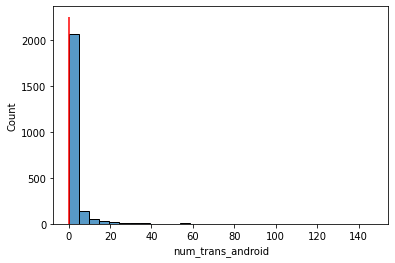

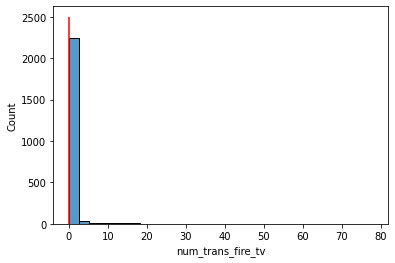

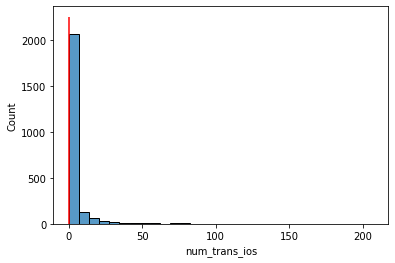

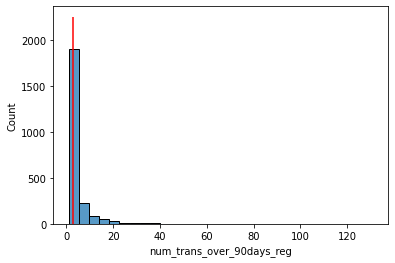

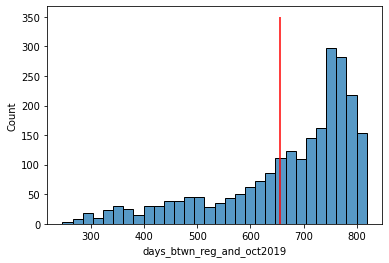

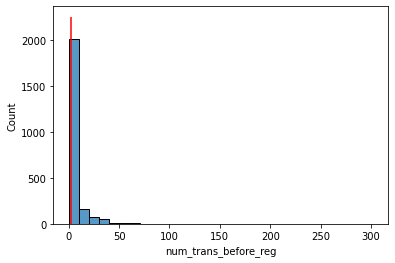

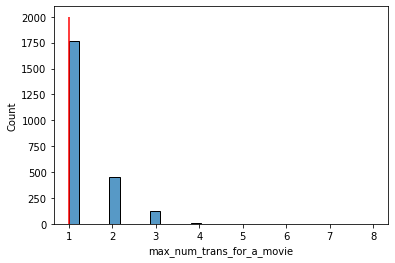

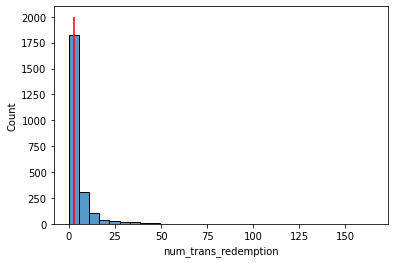

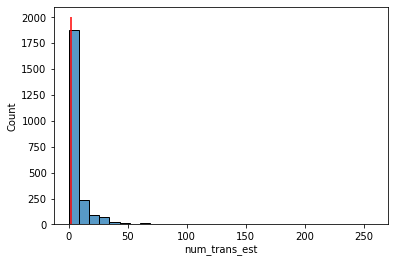

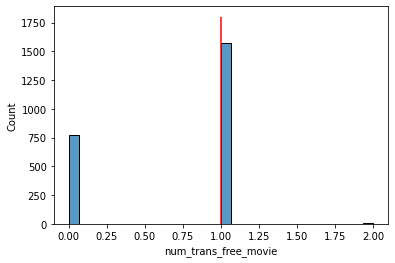

In [192]:
plot_incluster_action_list_histograms(df, col_list=action_list['col_name'], cluster_number=2, cluster_number_list=[1, 3], rep_user=rep_hau, savefig_prefix='churned_user_')

### Takeways:
   - Importance: Journey > Tansaction Type > Device Type
   - Persona:
       - old users, e.g. had registrated over 2 years
       - used to be active, e.g. had some purchases before registration
       - use IOS 
       - don't like to watch a same movie couple times
       - not interested in free movies
       - prefer the physical channel over the electronic channel
   - possible reason of churn: 
       - not enough IOS support, either on purchasing or watching 
       - used the wrong channel/platform for recommendation and free promotion campaign 
   - Proposed Actions:
       - improve IOS support 
       - improve registration process
       - use cookie to understand their website behaviors, e.g. major search engine, major device, movie & streaming contents (make sure they still active on other competitors' sites)
       - feed Ads to the right search engines and platforms, to show what's new in our platform and how we support and  deliver a good purchase/watching experience.